In [1]:
!pip install nexusformat

Defaulting to user installation because normal site-packages is not writeable


In [287]:
%autosave 60
import matplotlib.pyplot as plt
import numpy as np
from nexusformat.nexus import nxload

class Nexus_handling:
    def get_nexus_data_I06(self,file):
        """Function that loads the data from a nexus file and returns it as a list of numpy
arrays"""
        entry_string = "entry"
        data_region_list = []
        metadata_region_list = None
        x_array = file[entry_string]["instrument"]["fastEnergy"]["value"].nxvalue
        y_array = file[entry_string]["instrument"]["fesData"]["C1"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["C5"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["idio"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        y_array = file[entry_string]["instrument"]["fesData"]["ifiofb"].nxvalue
        data_region_list.append({"x": x_array, "y": y_array})
        magnet_field = file[entry_string]["instrument"]["scm"]["field_z"].nxvalue
        metadata_region_list = {"magnet_ﬁeld": magnet_field}
        polar = file[entry_string]["instrument"]["id"]["polarisation"].nxvalue
        metadata_region_list["polarisation"] = polar
        ###Add temperature values here
        ### Add angle of the beam here => 
        return data_region_list, metadata_region_list

    def open_single_spectra(self,ﬁle_number,directory_path,ﬁle_preﬁx,sensor):
        ﬁle_name = directory_path + ﬁle_preﬁx + str(ﬁle_number) + ".nxs"
        spectra_ﬁle = nxload(ﬁle_name)
        data,meta_data = self.get_nexus_data_I06(spectra_ﬁle)
        if sensor == "TEY":
            spectra = {"x" : data[2]["x"],"y":data[2]["y"],"meta" : meta_data}
        elif sensor == "TFY":
            spectra = {"x" : data[3]["x"],"y":data[3]["y"],"meta" : meta_data}
        return spectra

class XMCD_data_analysis(Nexus_handling):
    def __init__(self):
        self.on_oI_edge_points = [571, 576.9]
        self.directory_path = None
        self.ﬁle_preﬁx = None
        self.energy = None
        self.spectra = []
        self.hyst = []
        self.XMCD = []
        self.magz = []
        #self.temperature
    
    def set_directory_path(self, directory_path):
        self.directory_path = directory_path

    def set_ﬁle_preﬁx(self, ﬁle_preﬁx):
        self.ﬁle_preﬁx = ﬁle_preﬁx

    def load_spectra(self, directory_path, ﬁle_preﬁx, XMCD_spectra_Set,sensor = "TEY"):  
        self.directory_path = directory_path
        self.ﬁle_preﬁx = ﬁle_preﬁx

        if len(XMCD_spectra_Set) != 1:
            for ﬁle_number in XMCD_spectra_Set: 
                print(file_number)
                data_set = self.open_single_spectra(ﬁle_number, directory_path,  ﬁle_preﬁx,sensor)
                self.spectra.append(data_set)
                self.energy = self.spectra[0]["x"]
        else:
            print(XMCD_spectra_Set)
            data_set = self.open_single_spectra(XMCD_spectra_Set[0], directory_path,  ﬁle_preﬁx,sensor)
            self.spectra.append(data_set)
    
            self.energy = self.spectra[0]["x"]
#######################################################################################
    ### Plotting functions
    
    def plot_spectra(self,XAS_file_Set,i, bounds = None, normalisation = None):
        #Plots a single XAS spectra out of a set 
        #XAS_file_set : a set of XAS scan numbers
        #i : the indice of which scan you want to plot
        Energy,Idio = XMCD.spectra[i]["x"],XMCD.spectra[i]["y"]
        if bounds is not None:
            plt.xlim(bounds[0])
            plt.ylim(bounds[1])

        if normalisation is not None:
            value = np.mean(Idio[:normalisation])
            plotting_y = Idio - value
            plotting_y = plotting_y / np.max(plotting_y) 
        else:
            plotting_y = Idio

        
        plt.plot(Energy,plotting_y,label = XAS_file_Set[i])
        plt.title(("XAS ",sensor,XAS_file_set[i],self.spectra[i]["meta"]["polarisation"]))
        plt.legend()
        plt.xlabel("Energy(eV)")
        plt.ylabel("idio")   

    def Dichroism(self,XMCD_ﬁle_Set, avg = "Before"):
        #Takes in a series of XAS spectra of opposing polarisations then averages all the nc and all the pc and subtracts them to give us the dichroism
        # XMCD_file_Set : list of XAS spectra, at a minimum we need one of each polarisation of light.
        fig = plt.figure(figsize=(12, 6))
        ax = fig.subplots(1,3, sharey=True)  # (nrows, ncols, index)
        
        nc_storage = np.zeros(len(self.energy))
        pc_storage = np.zeros(len(self.energy))
        
        B_Field = self.spectra[0]["meta"]["magnet_ﬁeld"]
        fig.suptitle("Dichroism at " + str(np.round(B_Field)) +  "T ")
        print(B_Field)
        ax[0].set_title("pc")
        ax[1].set_title("nc")
        ax[2].set_title("XMCD")
        
        ax[1].set_xlabel("energy (eV")
        ax[0].set_ylabel("idio")
        
        n,m = 0,0
        for i in range(0,len(XMCD_file_Set)):
            Polarisation = self.spectra[i]["meta"]["polarisation"]
            F = self.spectra[i]["y"]
            f=np.polyfit(self.energy, F, 1)
            fit=np.polyval(f,self.energy)
            if Polarisation == "nc":
                nc_storage += F
                n += 1
                ax[0].plot(self.energy,(F-fit)+0.1,label = XMCD_file_Set[i] )
                ax[0].legend()

            elif Polarisation == "pc":
                pc_storage = pc_storage + F
                m = m + 1
                ax[1].plot(self.energy,(F-fit)+0.1,label = XMCD_file_Set[i] )
                ax[1].legend()

        if avg == "Before":
            nc_storage = nc_storage/n
            pc_storage = pc_storage/m
            dichroism = abs(pc_storage) - abs(nc_storage)
        
        ax[2].plot(self.energy,dichroism,label = "XMCD")
        ax[2].legend()

        for axs in ax:
            axs.axhline(y = 0, color = 'b', linestyle = 'dashed') 
            # axs.set_ylim(-0.05, 1)
        return self.energy,dichroism                    

def prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor):
    XMCD = XMCD_data_analysis()
    XMCD.load_spectra(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)
    return XMCD

print("Saved Code")
directory_path = r"FILES/"
ﬁle_preﬁx = "i06-1-"

print("ALL GOOD HERE BOSS")


Autosaving every 60 seconds
Saved Code
ALL GOOD HERE BOSS


# DAY 1

[346991]


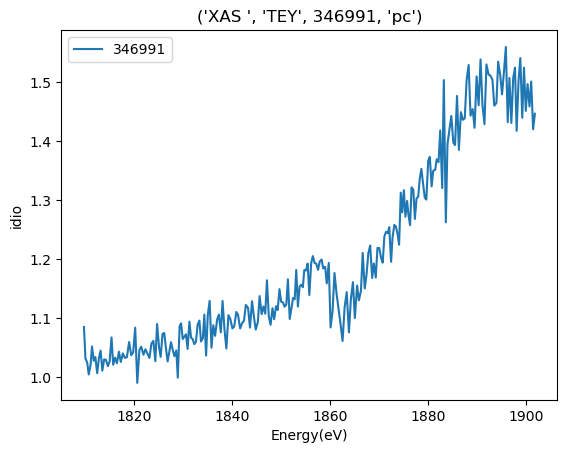

In [3]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/Finding the sample, 6983-7013/"
XAS_ﬁle_set=[346991]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra in the given list.
i = 0
for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i)
    i = i+1


### Cell above is first energy sweep from Beamtime. Trying to find Si edge

### 12:30 finding the sample and so doing lots of Y scans

### 12:45 Found out that CFF will influence the features seen in a spectra

### 12:51 Finished finding sample. Starting from 347014

[347014]


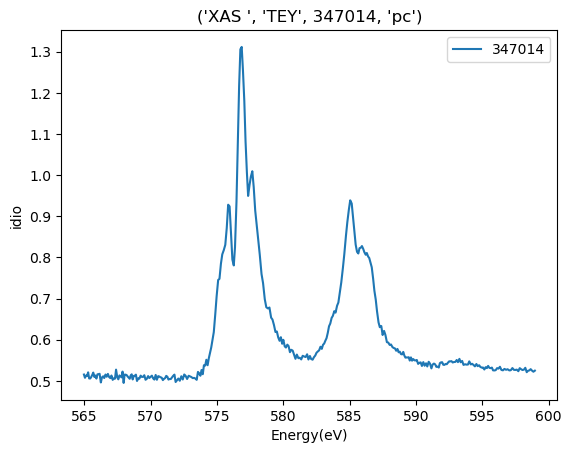

In [4]:
sensor = "TEY"
#sensor = "TFY"
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set=[347014]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra in the given list.
i = 0
for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i)
    i = i+1

### First scan back after lunch. ^

### Sets of scans to detect beam damage 

347016
347017
347018
347019
347020
347021
347022
347023
347024
347025


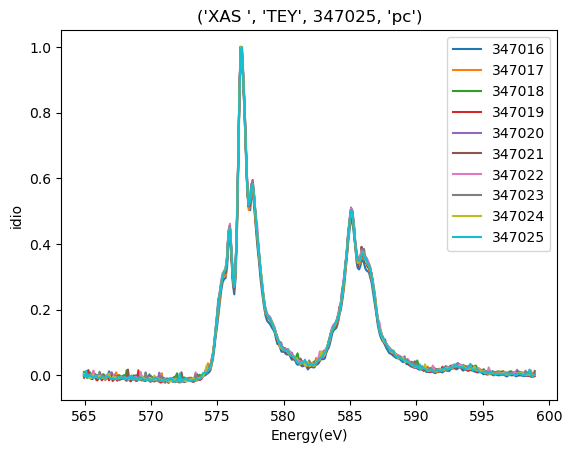

In [45]:
sensor = "TEY"
#sensor = "TFY"damage
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set=[347016,347017,347018,347019,347020,347021,347022,347023,347024,347025]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra in the given list.

for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i,  ,normalisation=5)  

### First 10 beam dmg check

347026
347027
347028
347029
347030
347031
347032
347033
347034


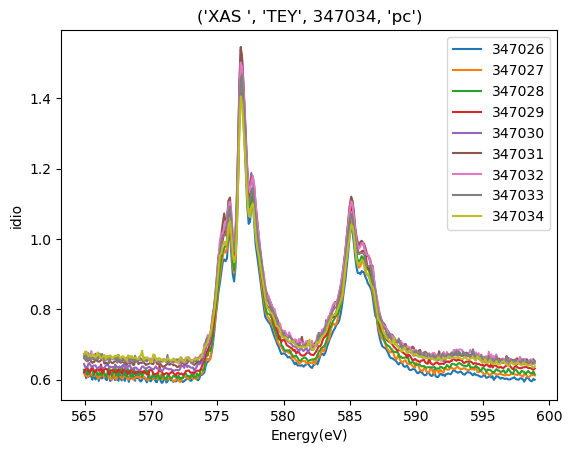

In [7]:
sensor = "TEY"
#sensor = "TFY"damage
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set=[347026,347027,347028,347029,347030,347031,347032,347033,347034] #include 34, 35

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra in the given list.
i = 0
for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i)
    i = i+1

### Next 10. new area^

### Now trying some XMCD at 0T. 

347034
347035


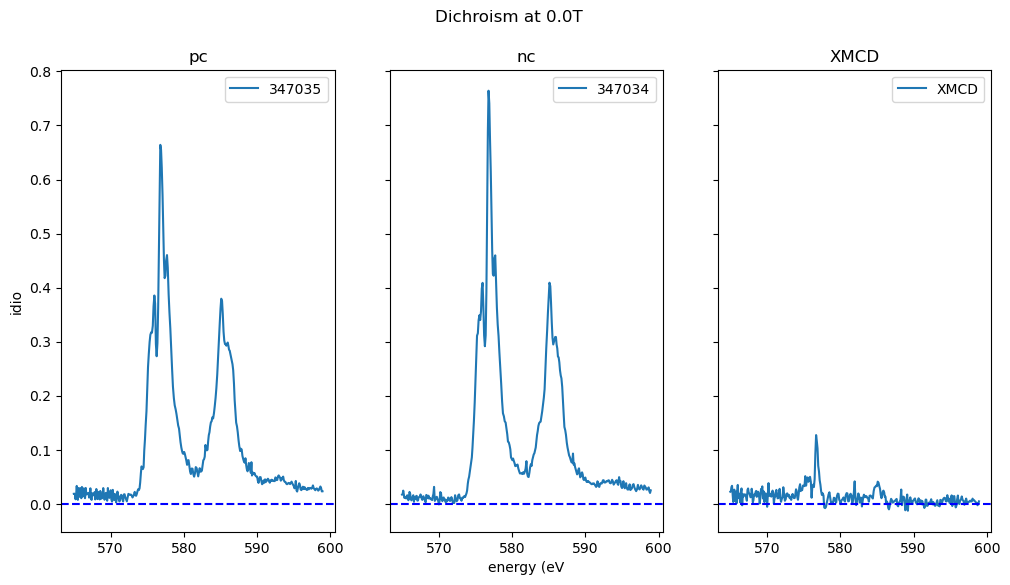

In [8]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347034,347035)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347036
347037


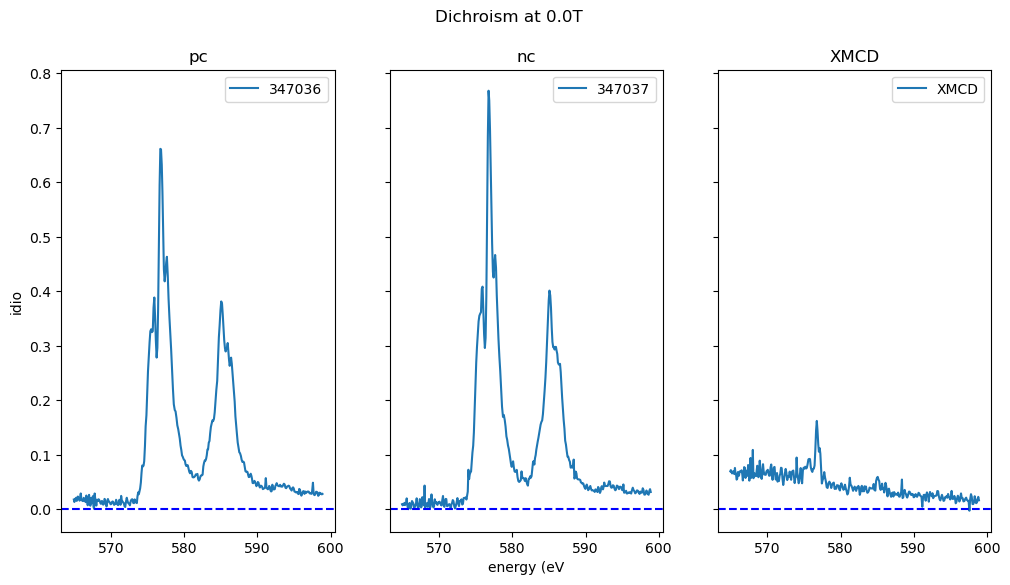

In [9]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347036,347037)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

### 15:16 These two XMCDs are most likely drift

347038
347039


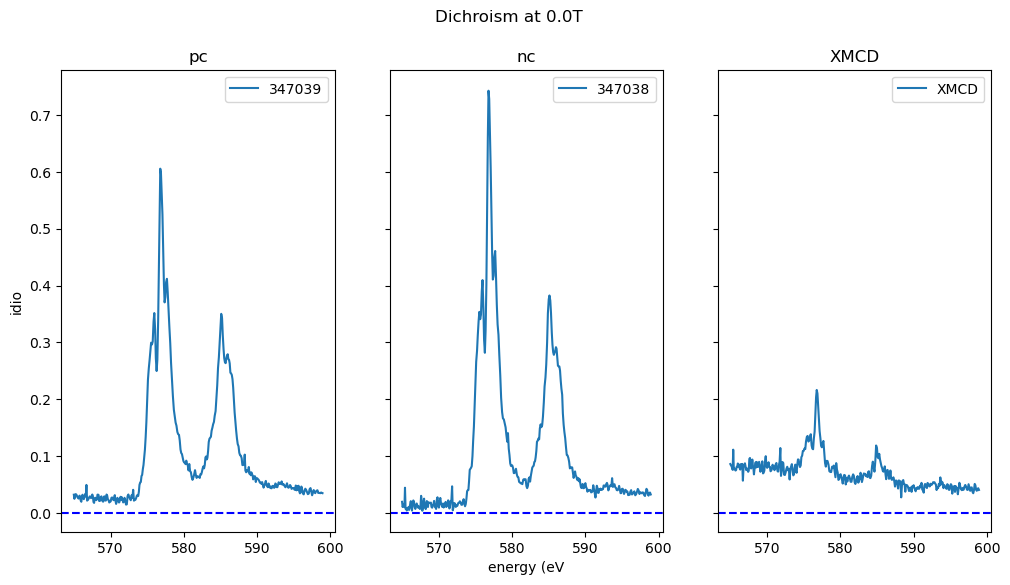

In [10]:

sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347038,347039)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347040
347041


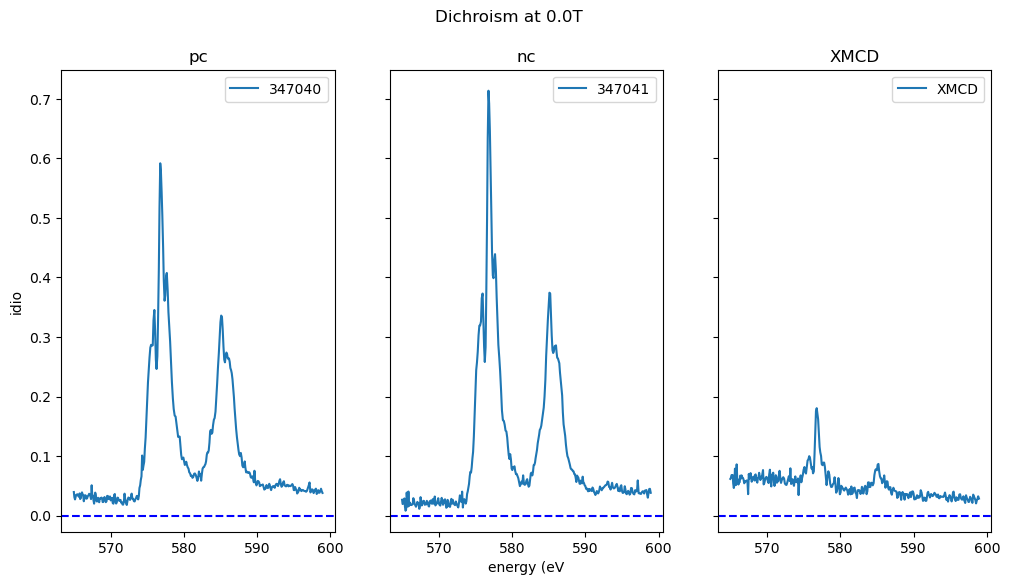

In [11]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347040,347041)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347042
347043


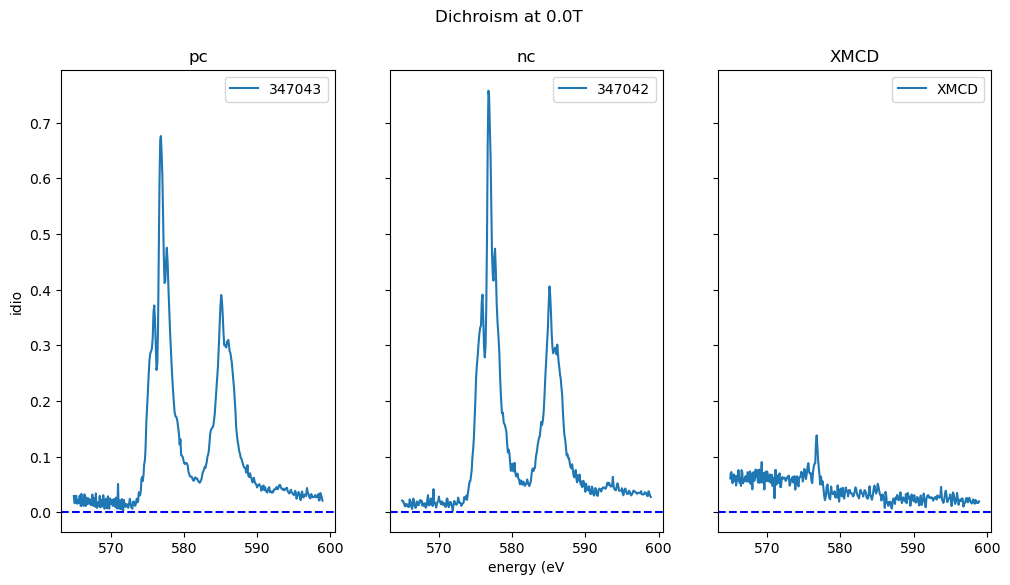

In [34]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347042,347043)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347044
347045


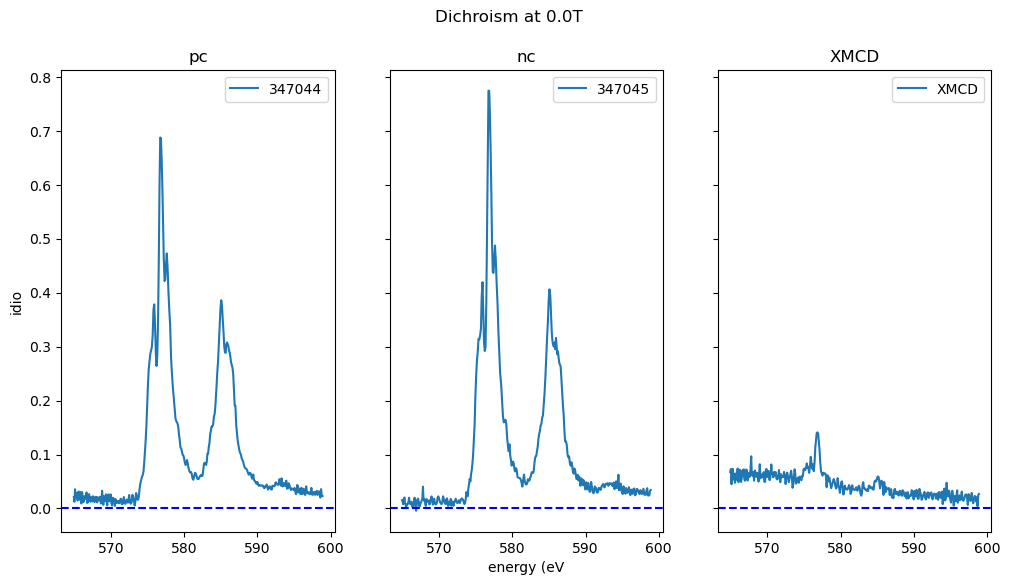

In [64]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347044,347045)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)


### 15:57 These were XMCDs of HOPG at 1.7ishK. All showing some signs in XMCD but mostly drift probably. Just filled 

347046
347047
347048
347049
347050
347051
347052


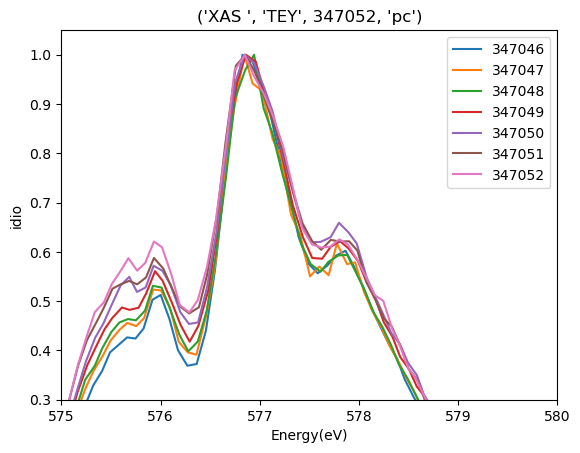

In [49]:
sensor = "TEY"
#sensor = "TFY"damage
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set=[347046,347047,347048,347049,347050,347051,347052] #

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra in the given list.
for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i, bounds = [[575,580],[0.3,1.05]], normalisation = 5)

Bosh
Bosh
Bosh
Bosh
Bosh
Bosh
Bosh
Bosh
Bosh
Bosh


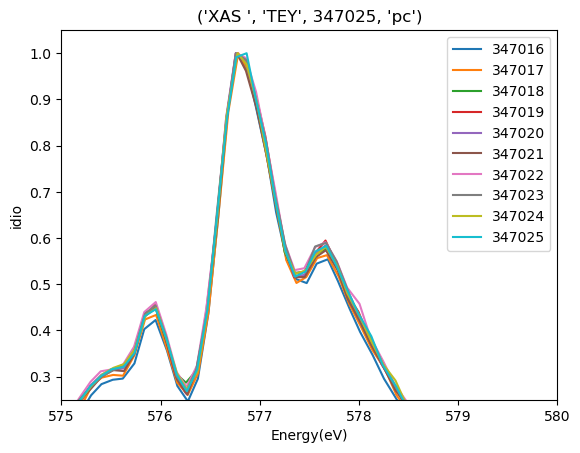

In [81]:
sensor = "TEY"
#sensor = "TFY"damage
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set=[347016,347017,347018,347019,347020,347021,347022,347023,347024,347025]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra in the given list.

for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i ,bounds = [[575,580],[0.25,1.05]],normalisation=5)  

### 16:32 ^ clearly showing beam damage after changing the cff. See powerpoint for details


347054
347055
347056
347057
347058
347059
347060
347061


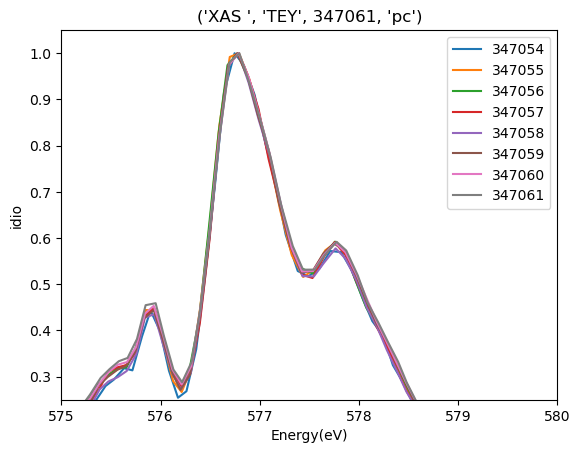

In [59]:
sensor = "TEY"
#sensor = "TFY"damage
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set= [347054,347055,347056,347057,347058,347059,347060,347061]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

####This line plots all the spectra in the given list.

for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i ,bounds = [[575,580],[0.25,1.05]],normalisation=5)  

### 16:45 Also checked florensces and it looks bad. Worth checking on ones above ^

[347062]


IndexError: list index out of range

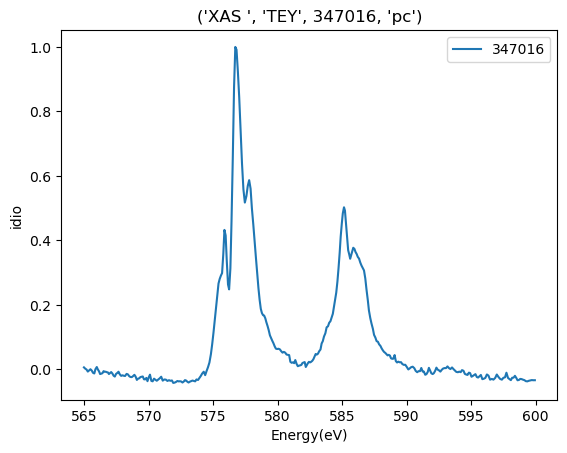

In [83]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_Set = [347062]XMCD
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
for i in range(len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i ,normalisation=5)  

347063
347064


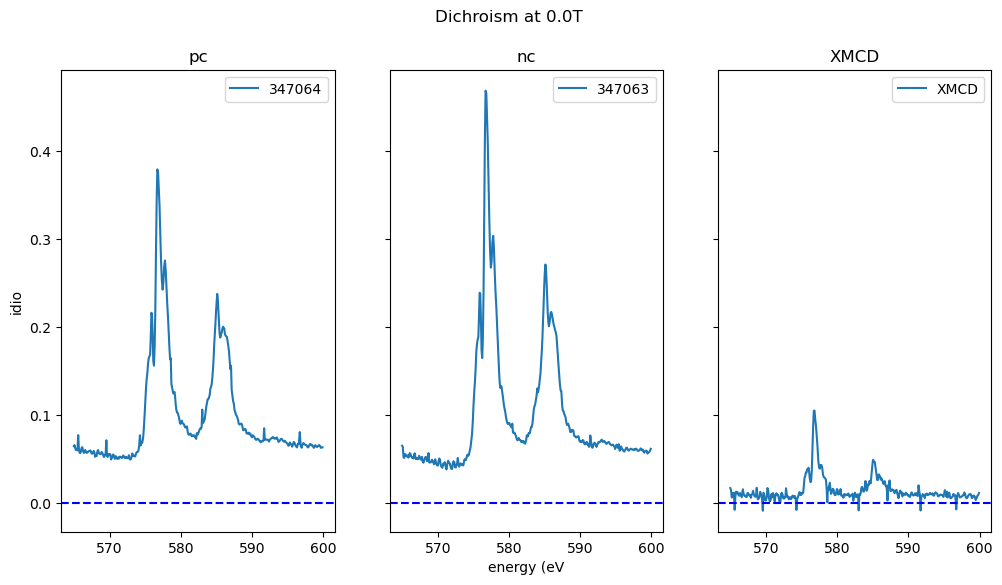

In [84]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347063,347064)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347065
347066


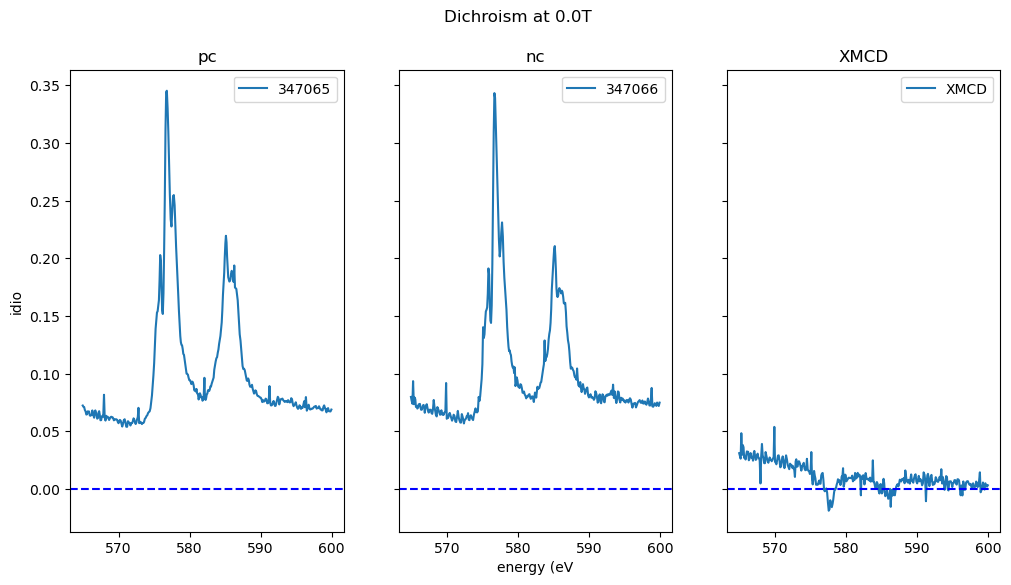

In [85]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347065,347066)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)


### 30 microns and 10 cff just some final checks

347068
347069
347070
347071
347072
347073
347074
347075
347076


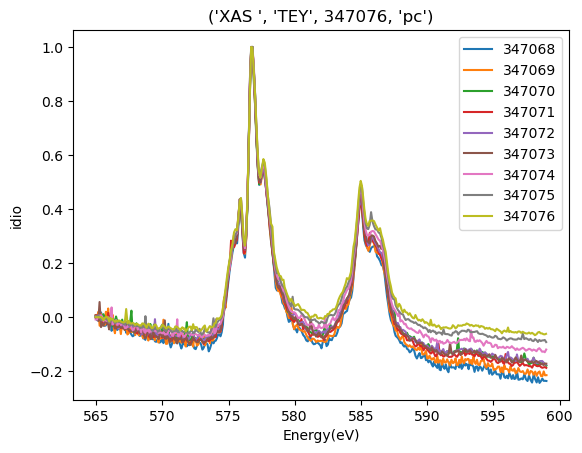

In [105]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set= [347068,347069,347070,347071,347072,347073,347074,347075,347076]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i ,normalisation=5)  

### 17:34 XMCD

347077
347078


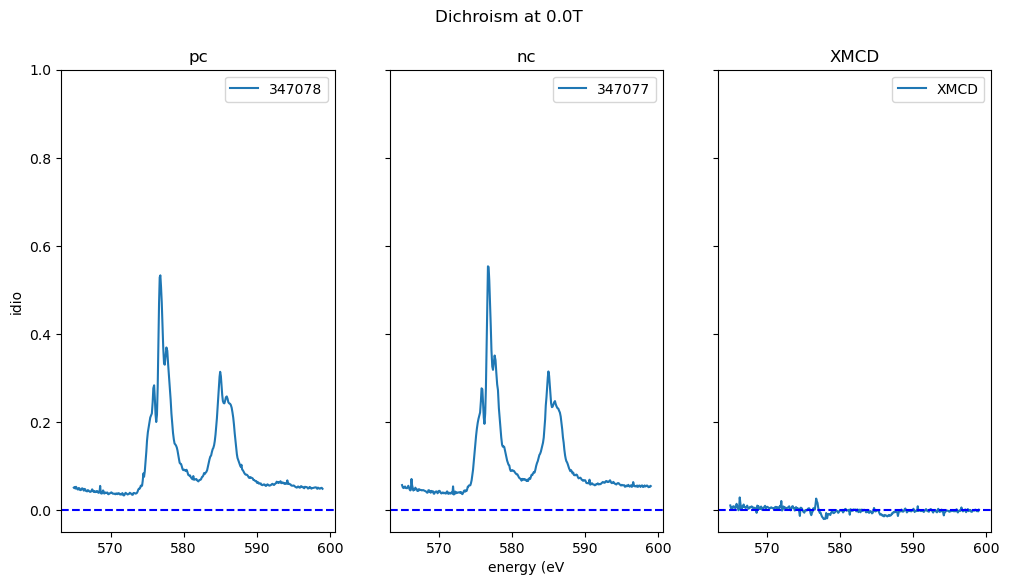

In [123]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347077,347078)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347079
347080


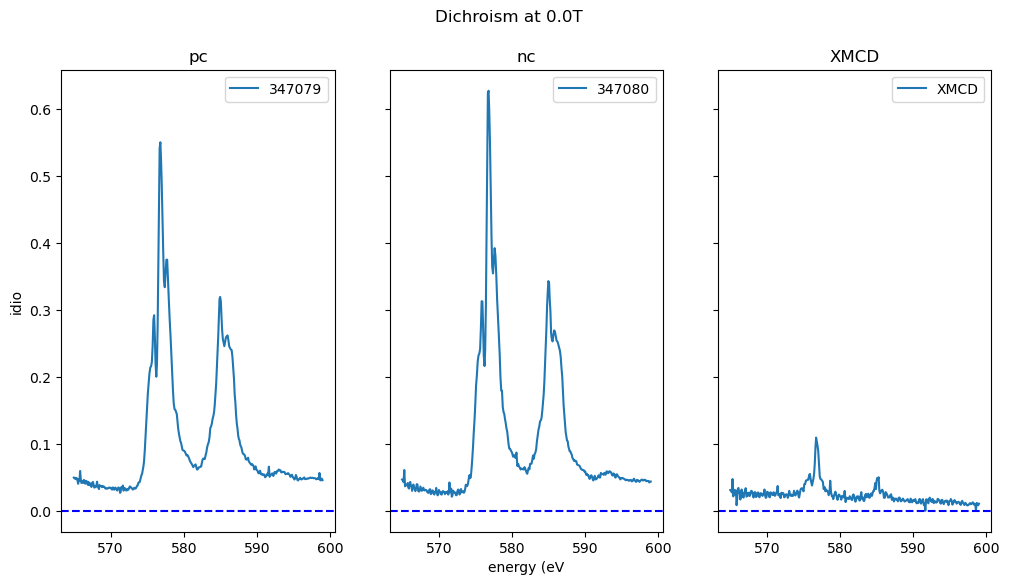

In [91]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347079,347080)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347081
347082


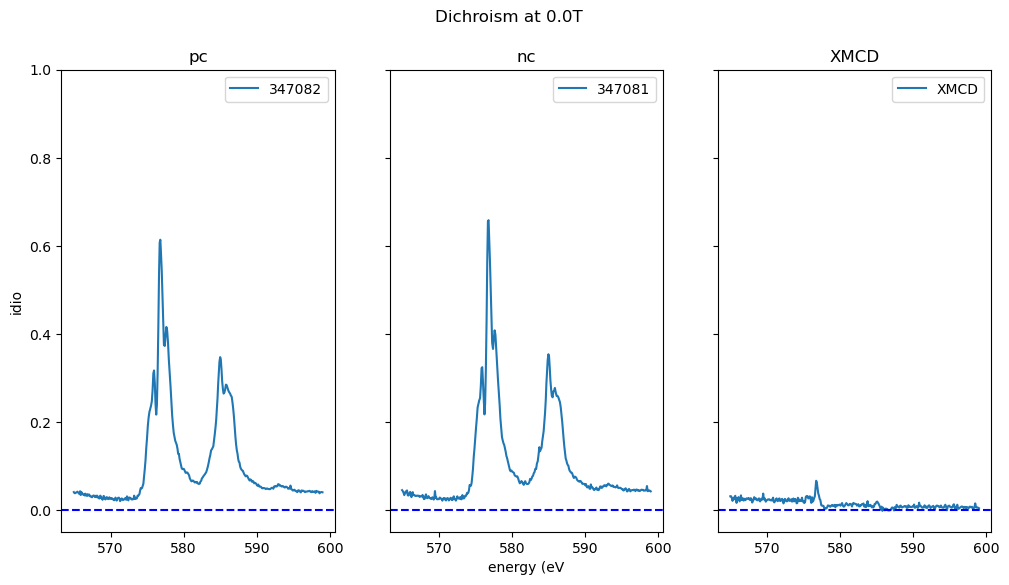

In [124]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347081,347082)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347086
347087


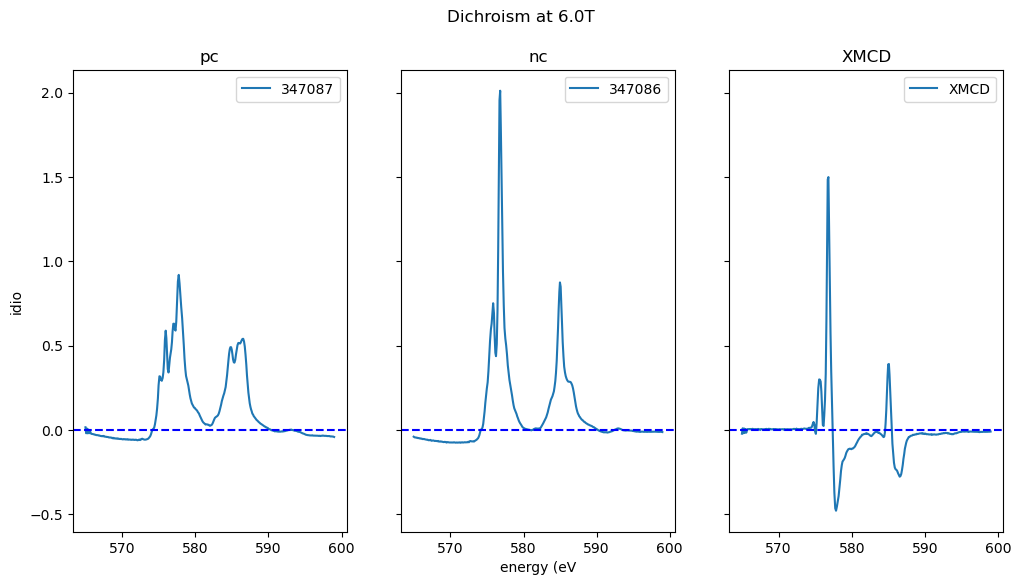

In [95]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347086,347087)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

### 18:13 Woah look at that signal

347088
347089


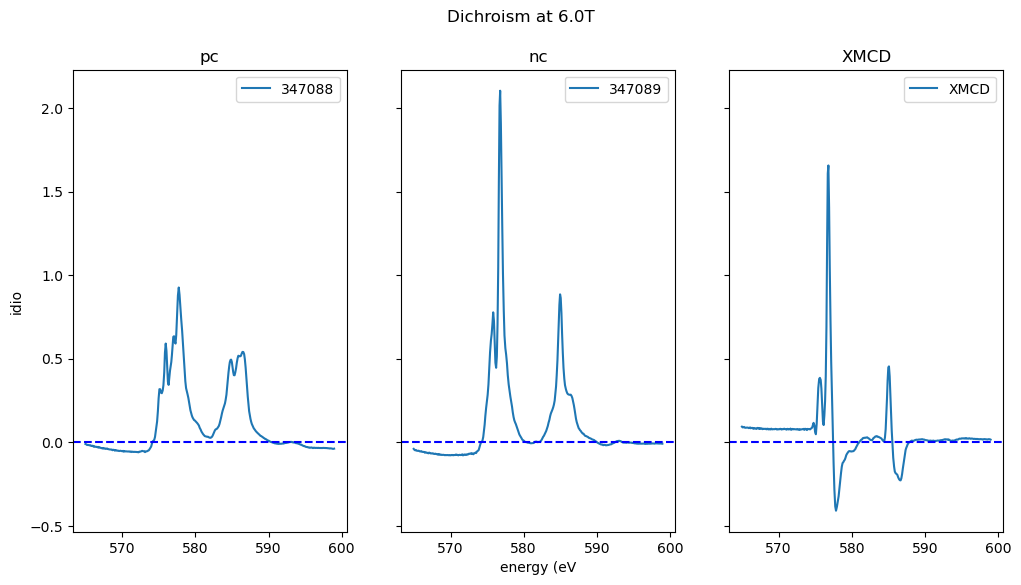

347090
347091


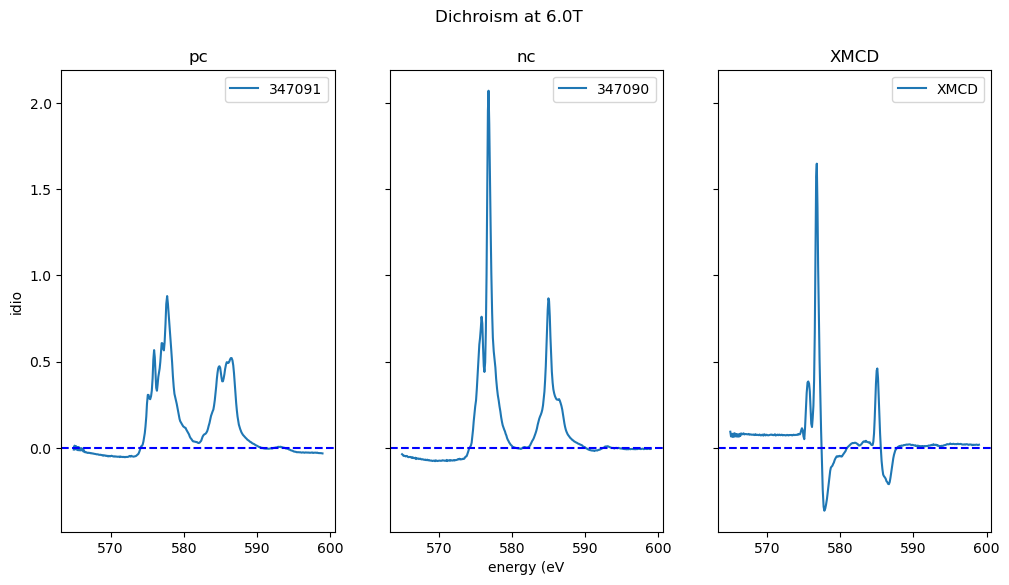

In [100]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347090,347091)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347092
347093


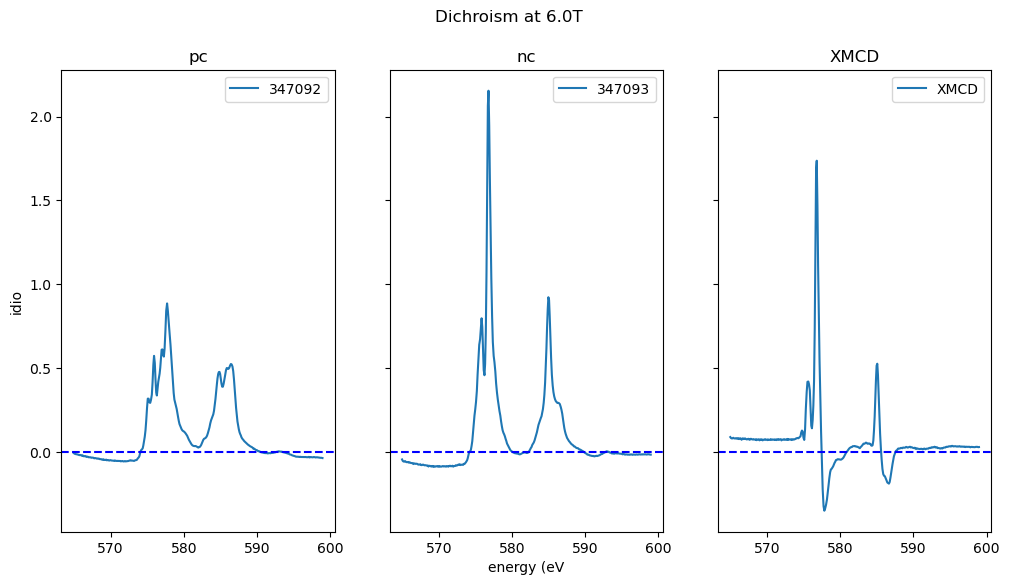

In [101]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"Abort next 2s
XMCD_ﬁle_Set = (347092,347093)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347086
347087
347088
347089
347090
347091
347092
347093


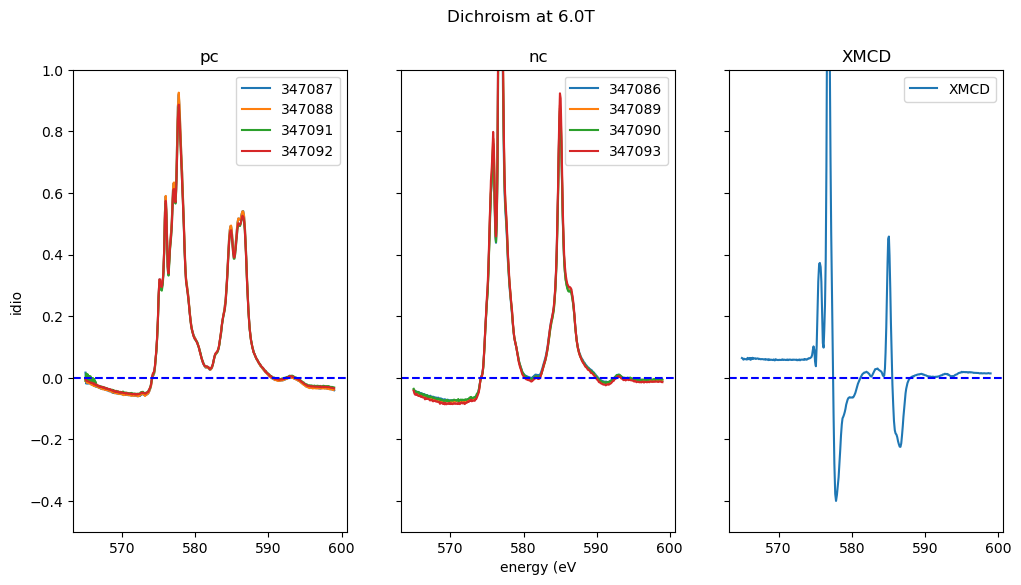

In [119]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347086,347087,347088,347089,347090,347091, 347092,347093)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347094
347095


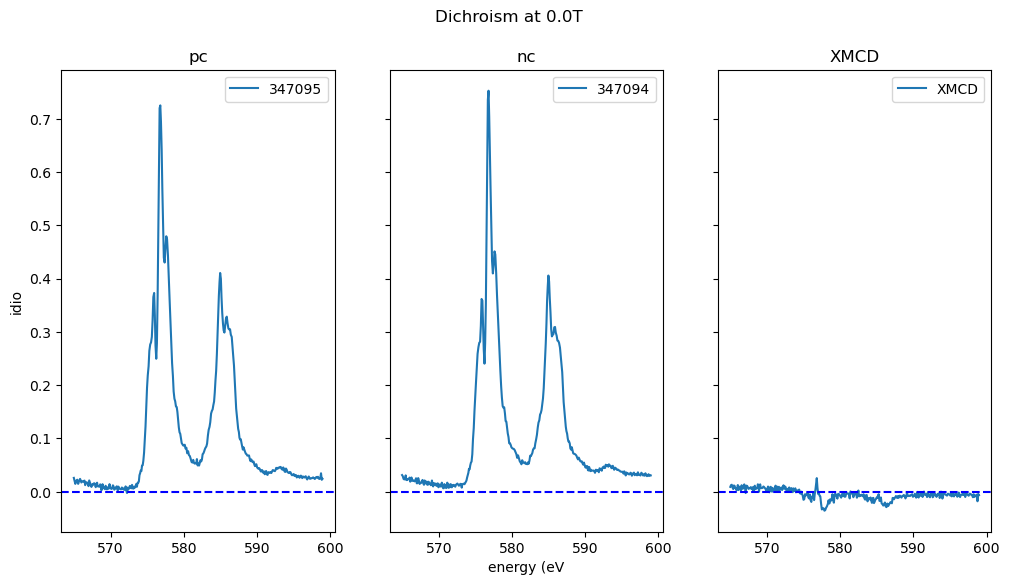

In [103]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347094,347095)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347096
347097


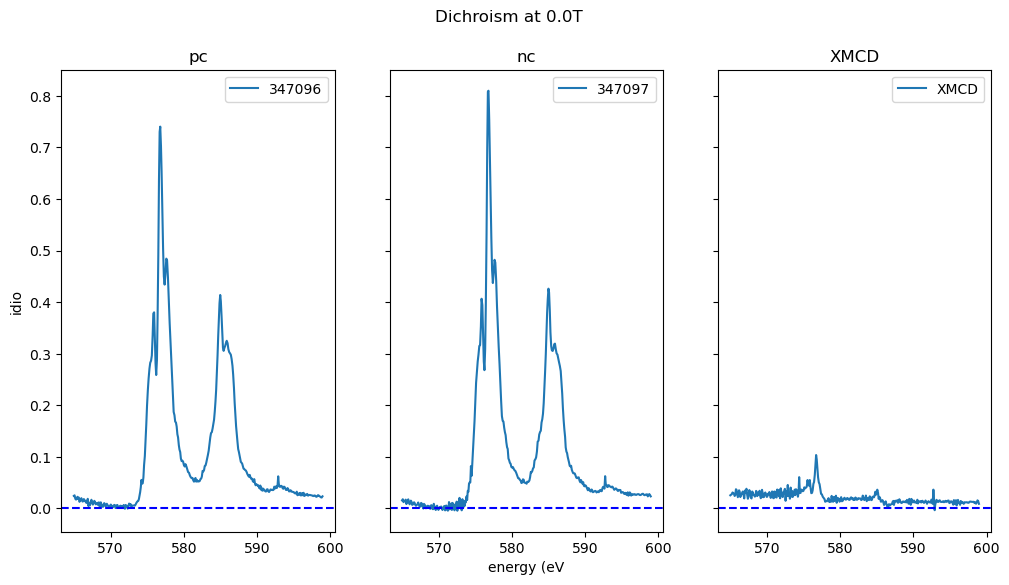

In [104]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347096,347097)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347098
347099


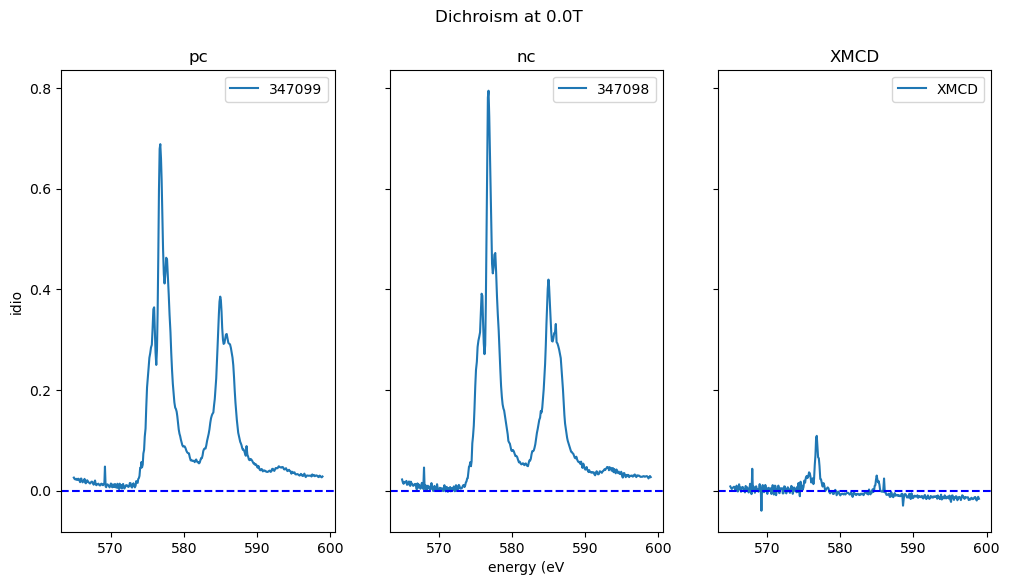

In [106]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347098,347099)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347100
347101


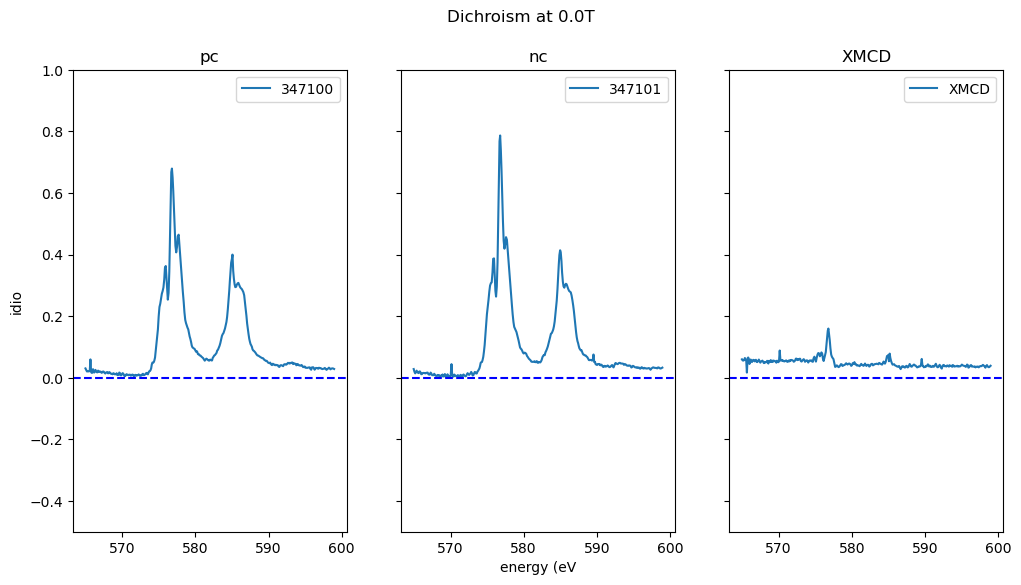

In [118]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347100,347101)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347094
347095
347096
347097
347098
347099
347100
347101


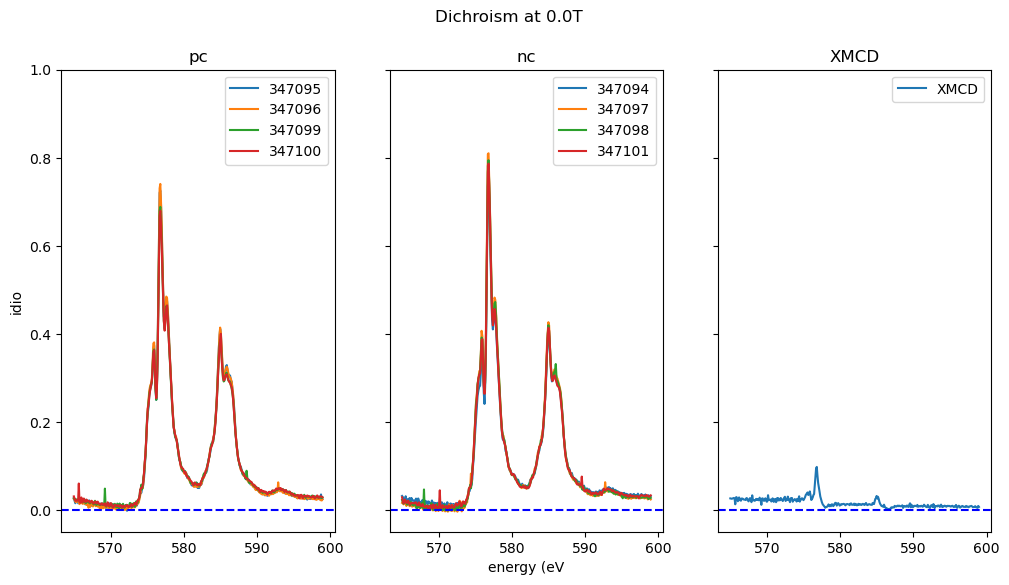

In [125]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347094,347095,347096,347097,347098,347099,347100,347101)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347094
347095
347096
347097
347098
347099


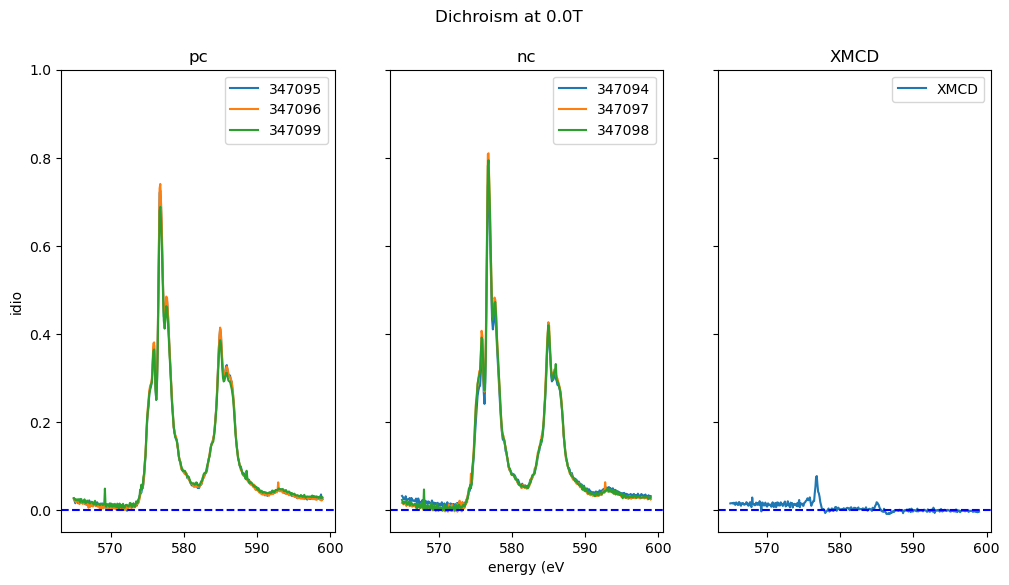

In [126]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347094,347095,347096,347097,347098,347099)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347102
347103


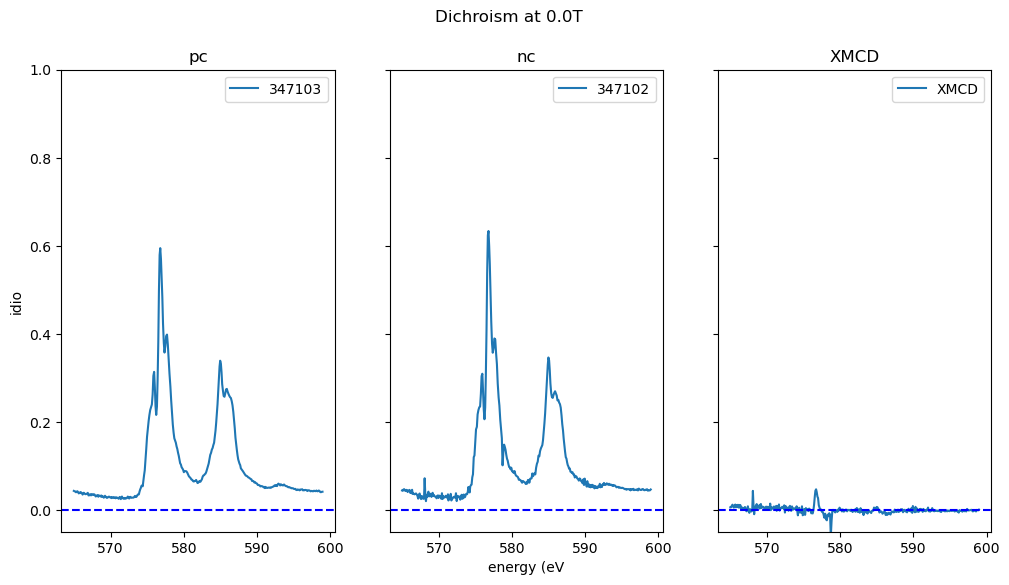

In [127]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347102,347103)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347104
347105


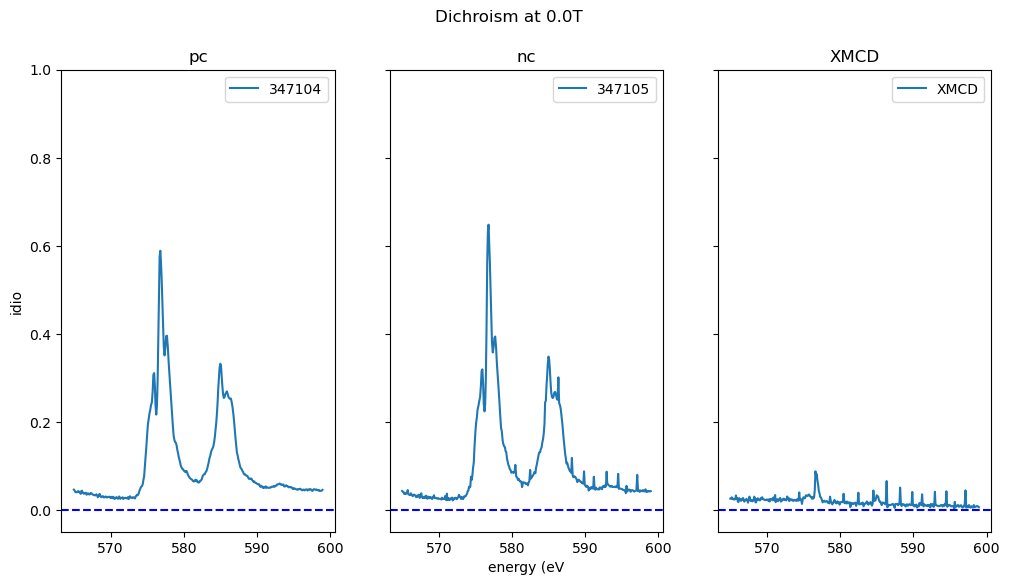

In [128]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347104,347105)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

## 19:19 MAYBE SOMETHING >>>>>> LOOKING INTO THIS

### Running hystersis loop over dinner, 106,107,108,109

### 10mT XMCD 

347119
347120


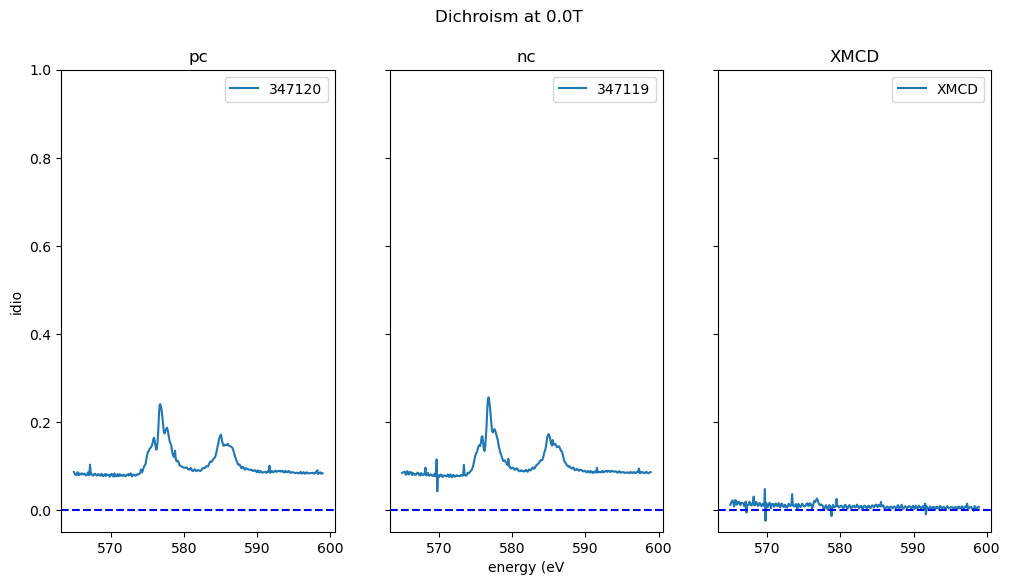

In [129]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347119,347120)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347121
347122


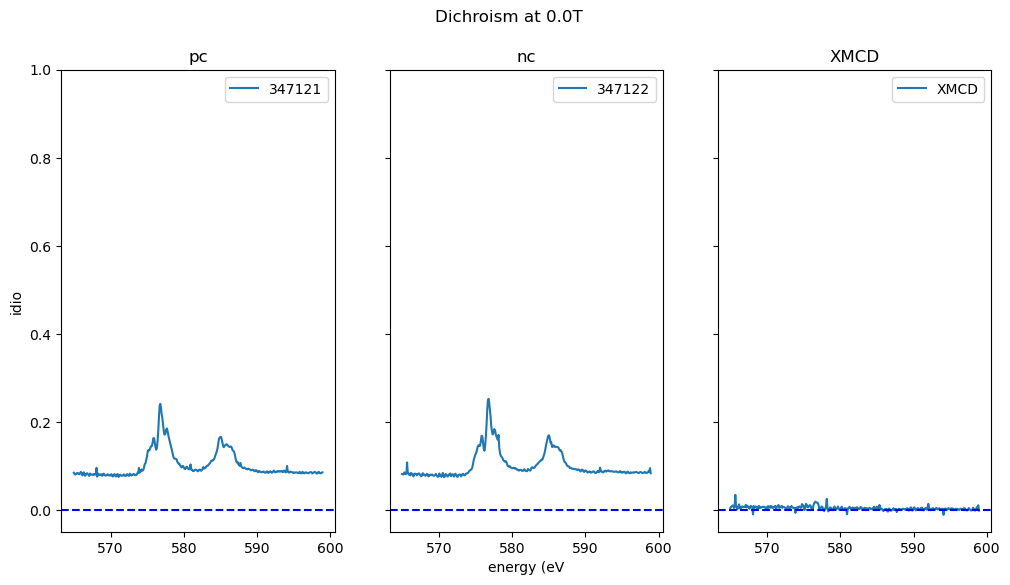

In [130]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347121,347122)05T05T
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347123
347124


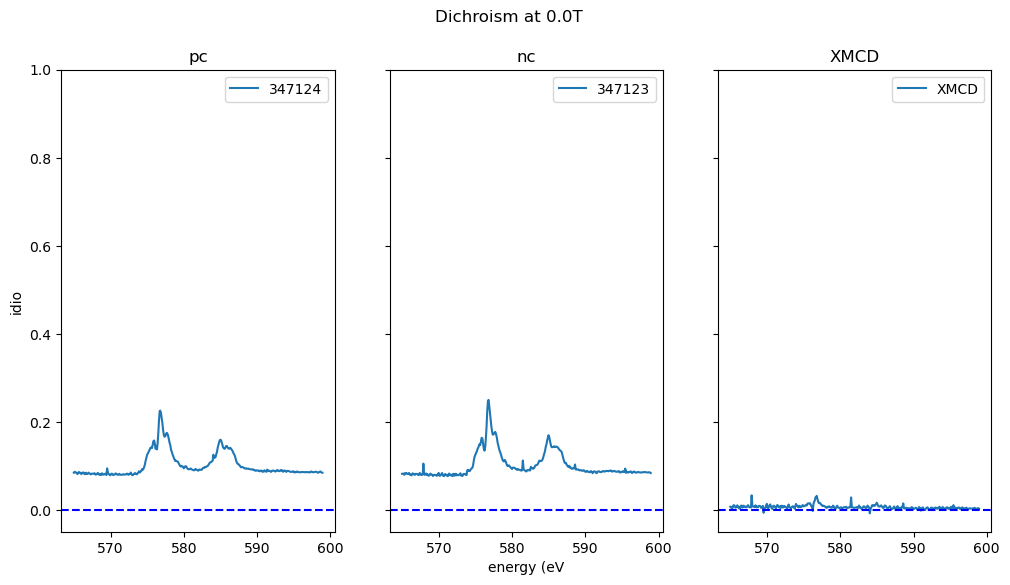

In [131]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347123,347124)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347125
347126


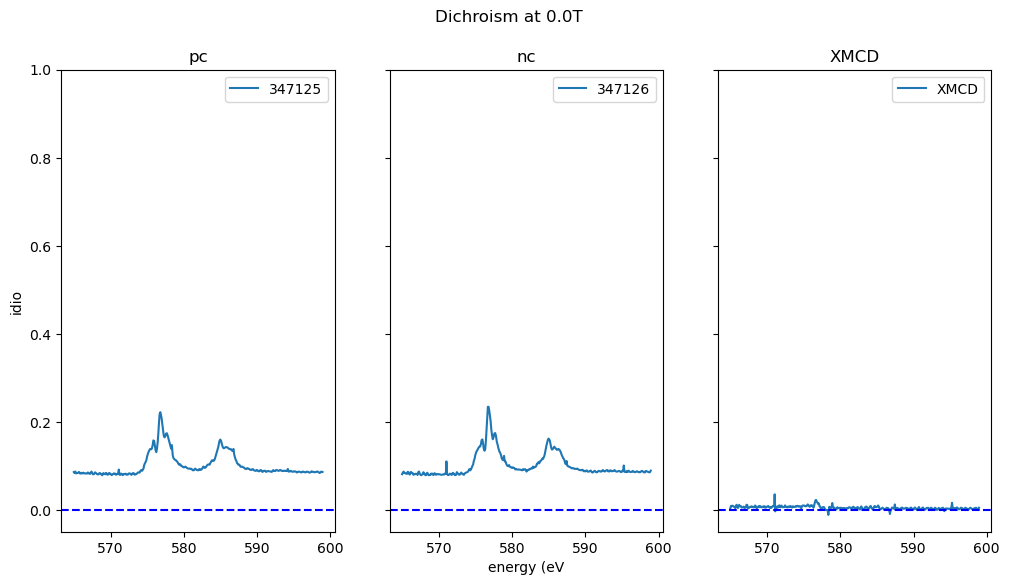

In [132]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347125,347126)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347119
347120
347121
347122
347123
347124
347125
347126


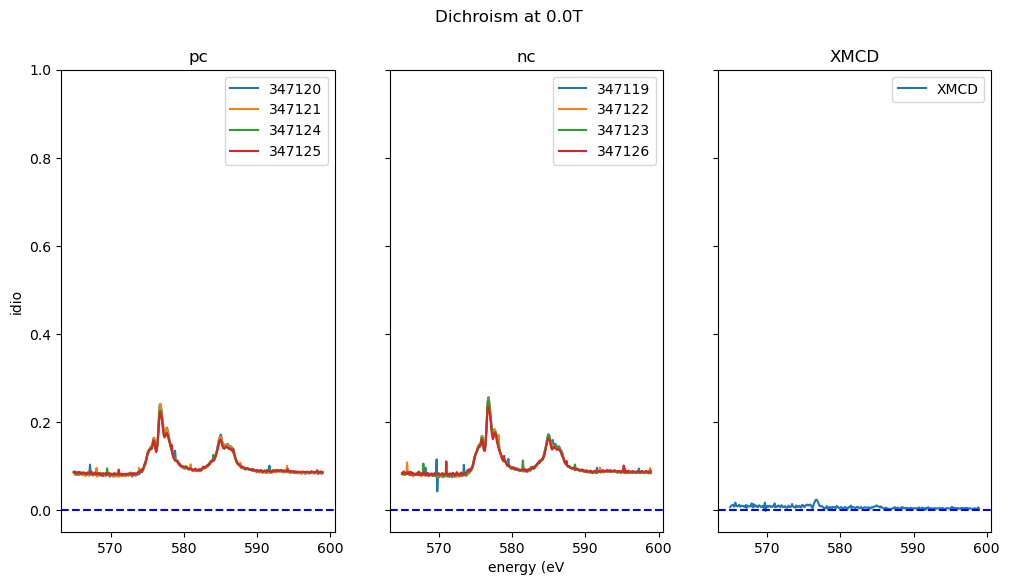

In [133]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347119,347120,347121,347122,347123,347124,347125,347126)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

### 5mT

347111
347112
347113
347114
347115
347116
347117
347118


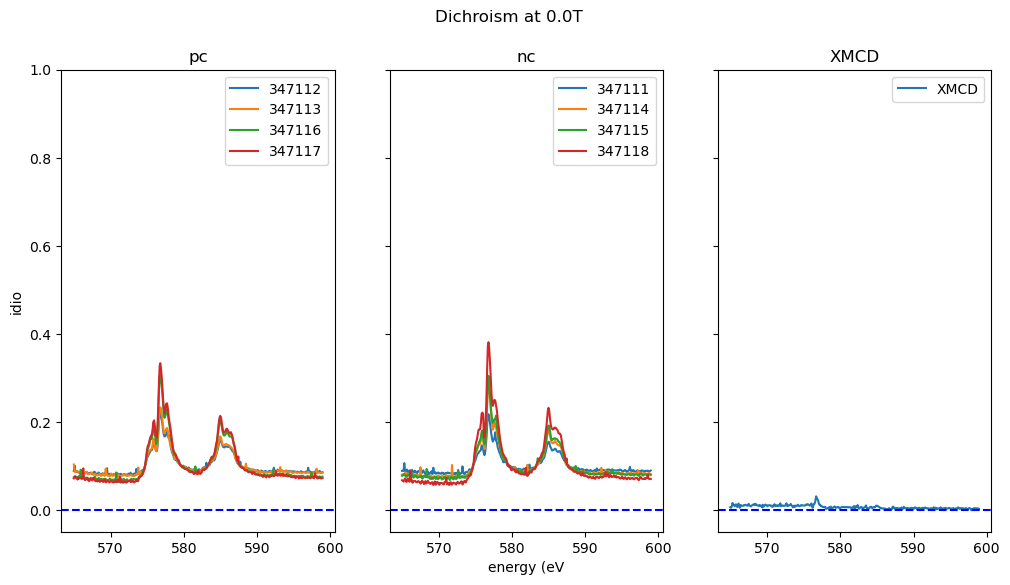

In [134]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347111,347112,347113,347114,347115,347116,347117,347118)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347111
347112


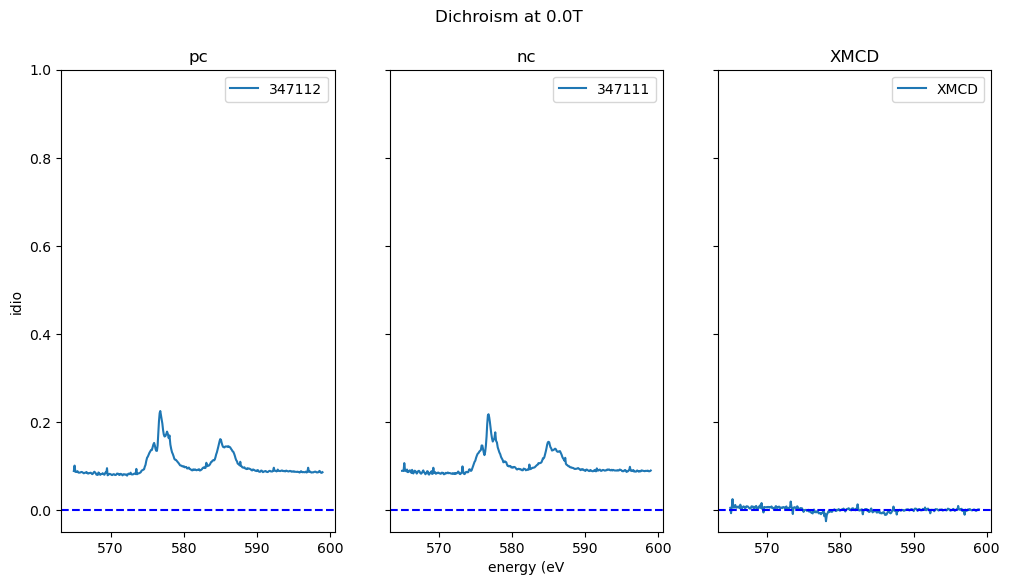

In [135]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347111,347112)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347113
347114


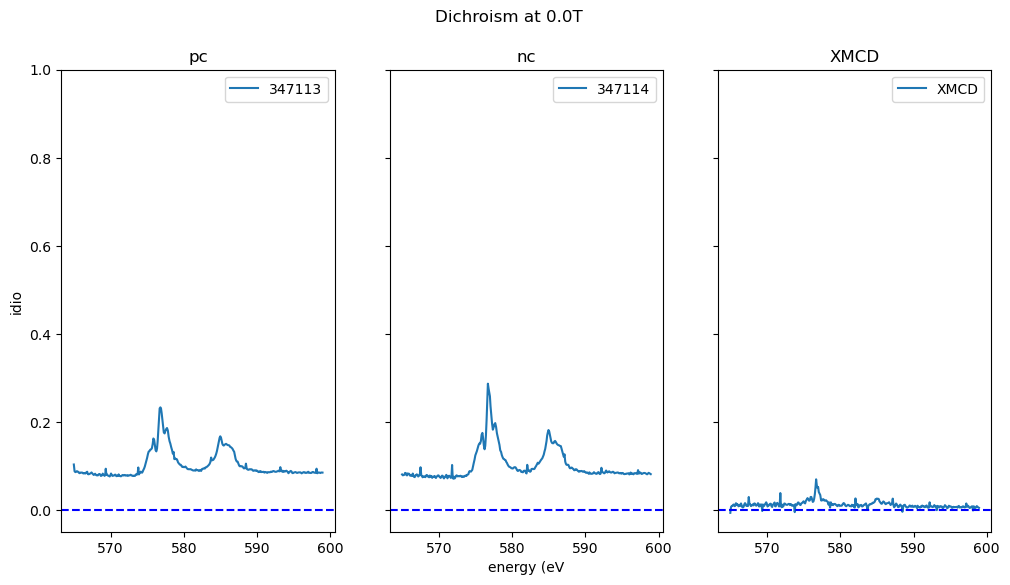

In [136]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347113,347114)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347115
347116


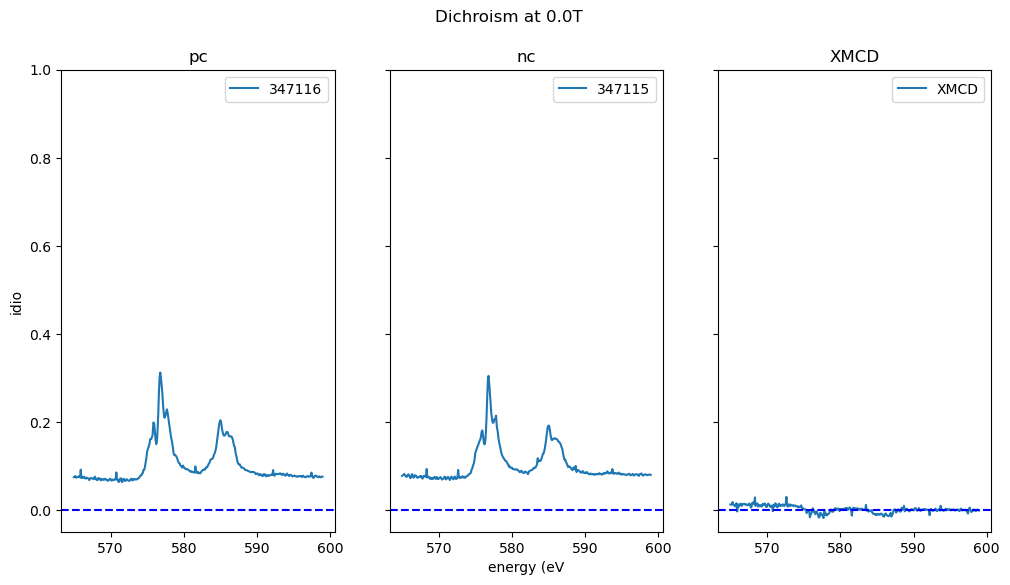

In [137]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347115,347116)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347117
347118


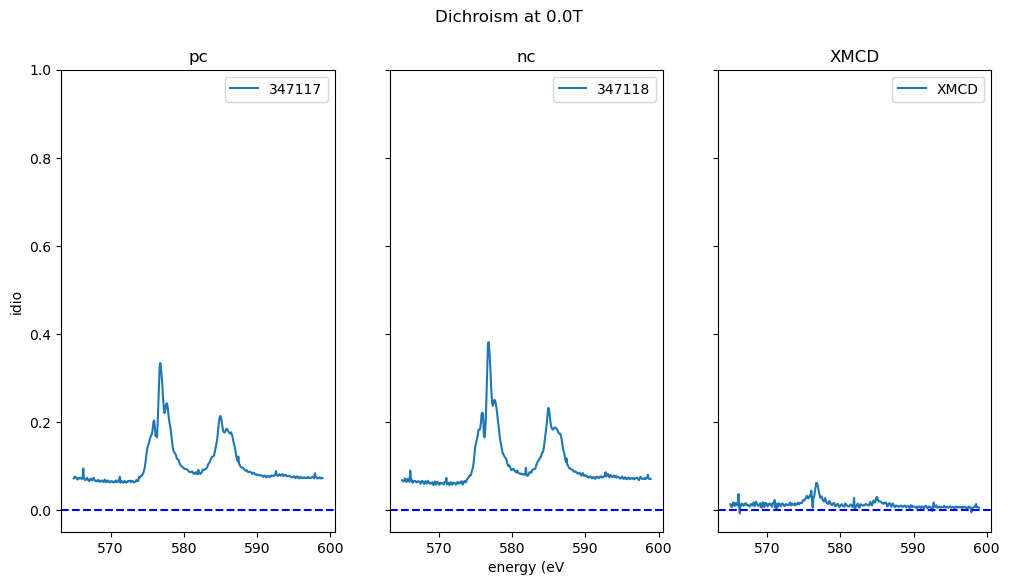

In [138]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347117,347118)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347127
347128
347129
347130
347131
347132
347133
347134


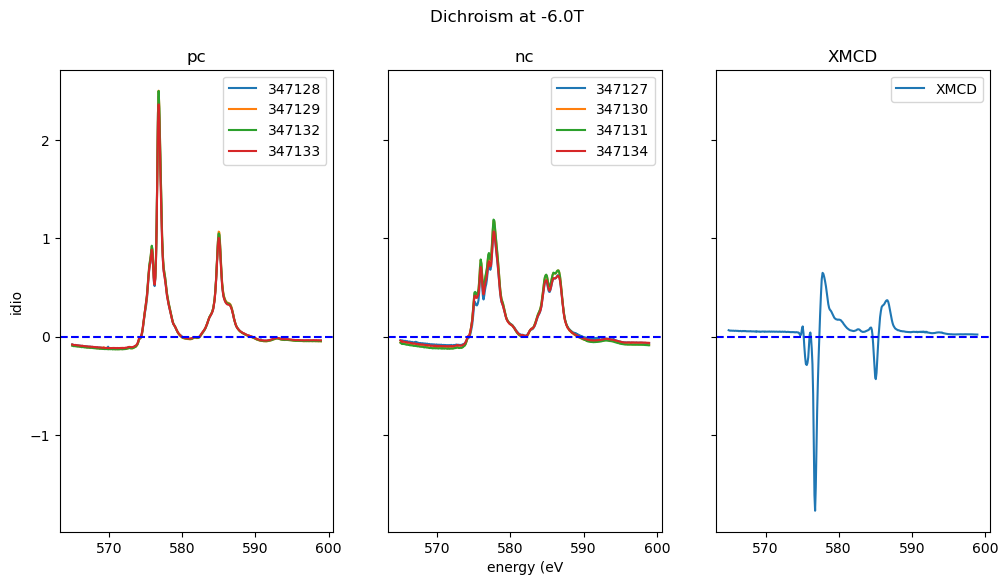

In [145]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347127,347128,347129,347130,347131,347132,347133,347134)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347127
347128


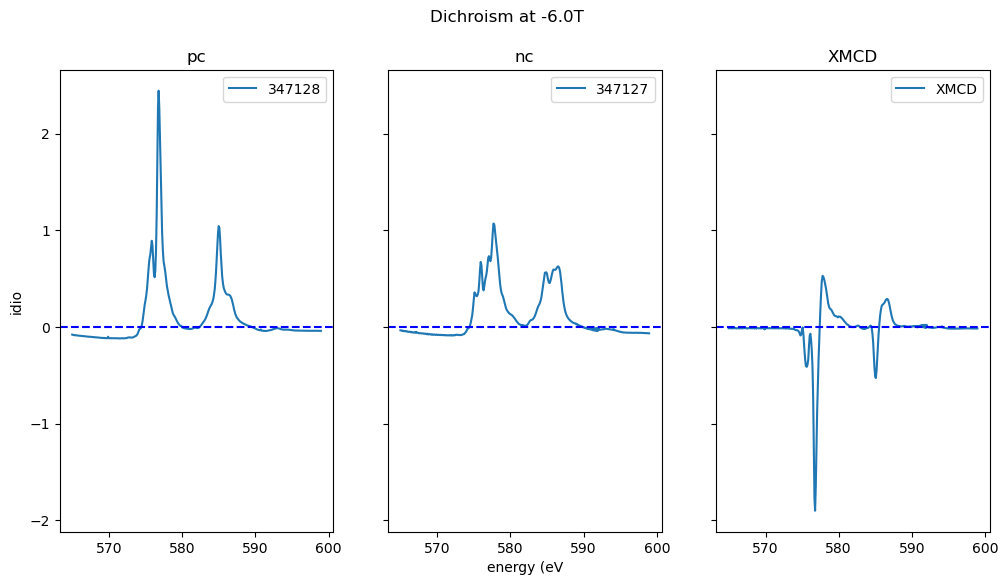

In [146]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347127,347128)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347129
347130


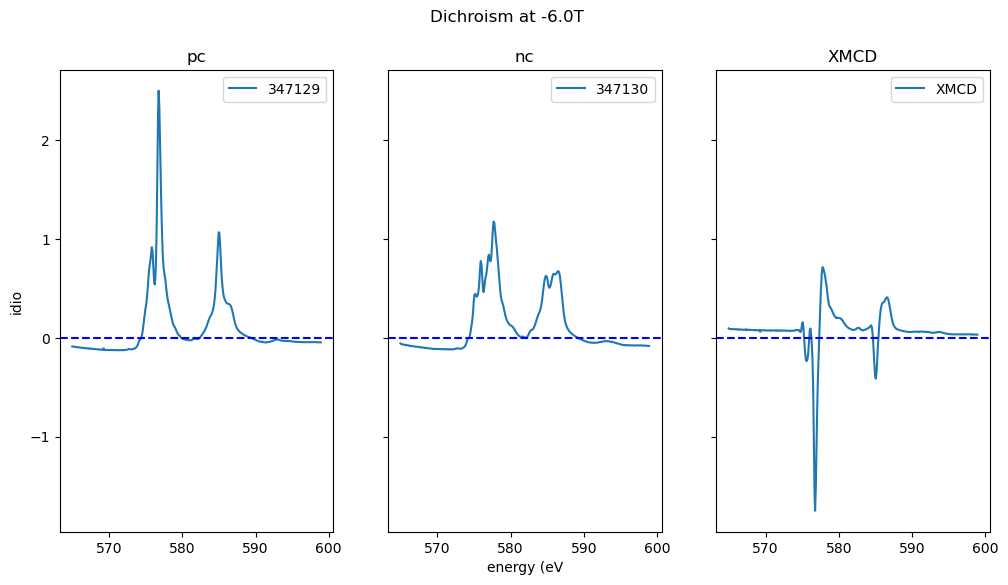

In [147]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347129,347130)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347131
347132


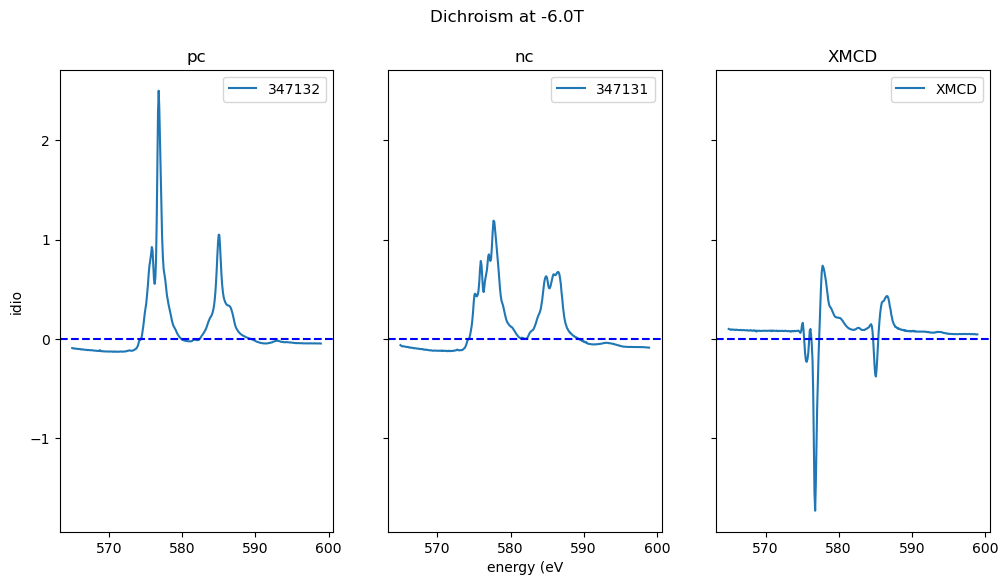

In [148]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347131,347132)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347133
347134


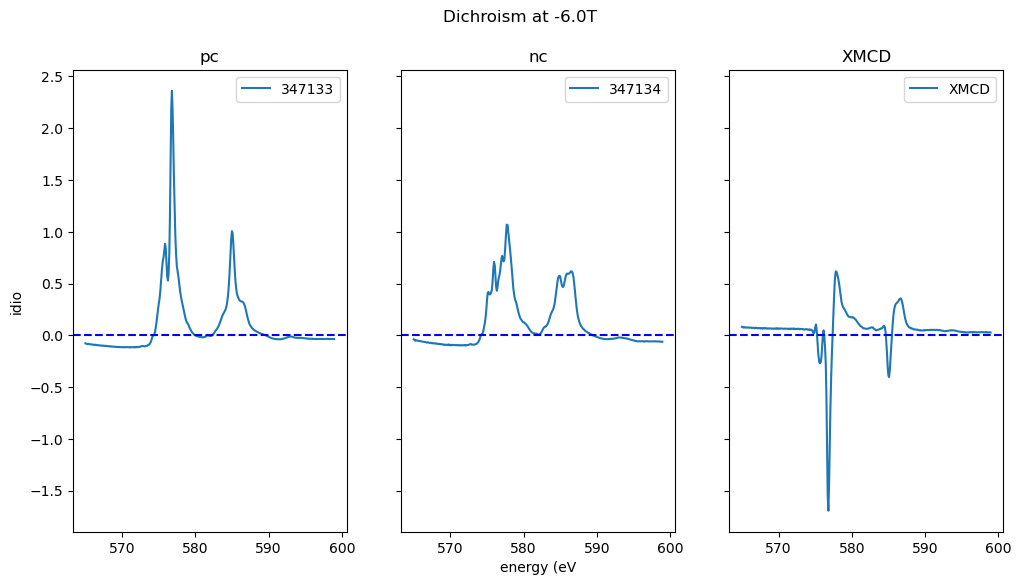

In [149]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347133,347134)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347136
347137


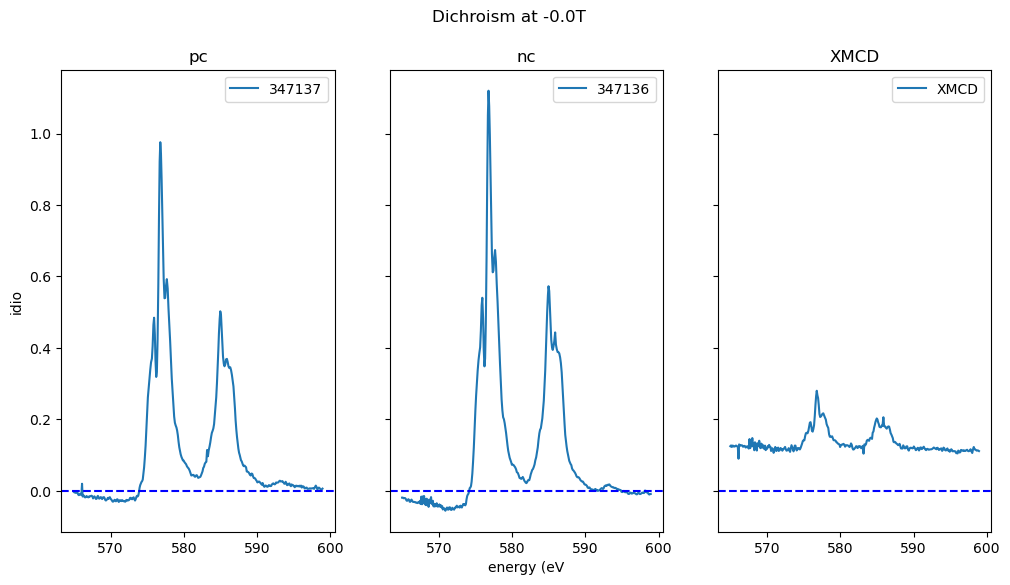

In [160]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347136,347137)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347138
347139


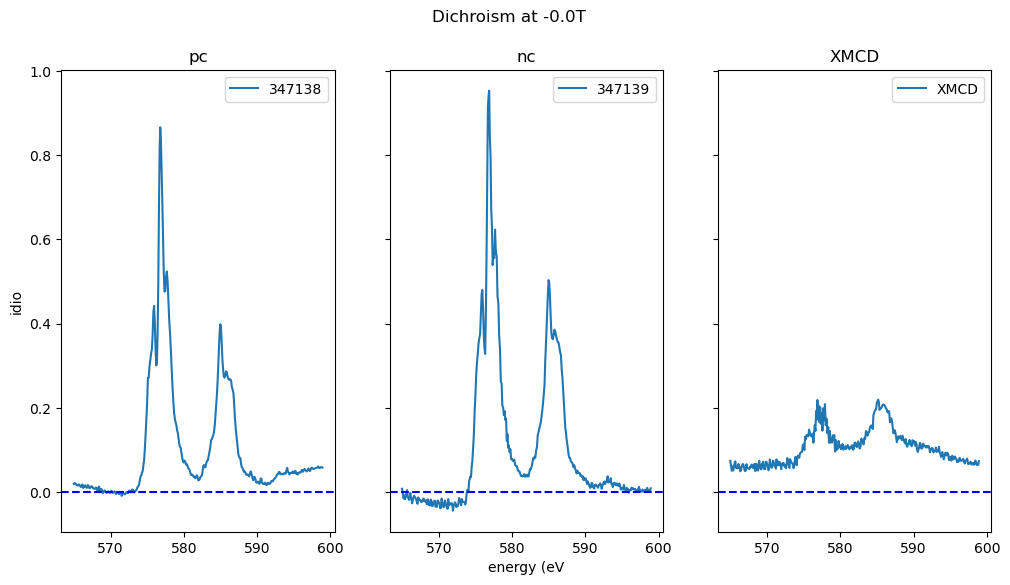

In [159]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347138,347139)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347141
347142


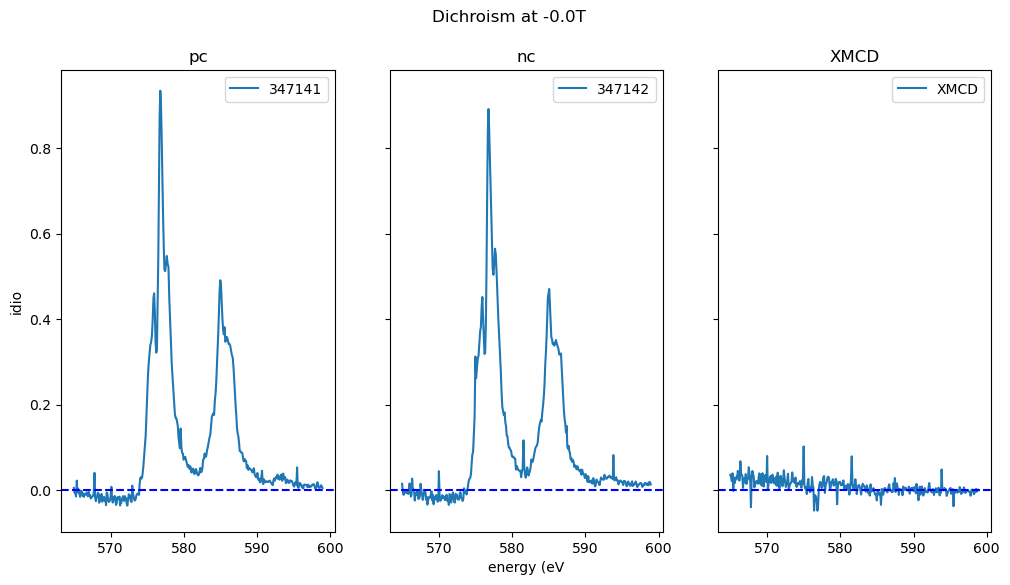

In [158]:
sensor = "TEY"2025-01-29 23:00:53,836 INFO  gda.data.fileregistrar.FileRegistrar - icatXMLCreator.registerFiles started: datasetId = scan-347150
2025-01-29 23:00:53,836 INFO  gda.data.fileregistrar.FileRegistrar - icatXMLCreator.registerFiles started: datasetId = scan-347150

directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347141,347142)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347143
347144


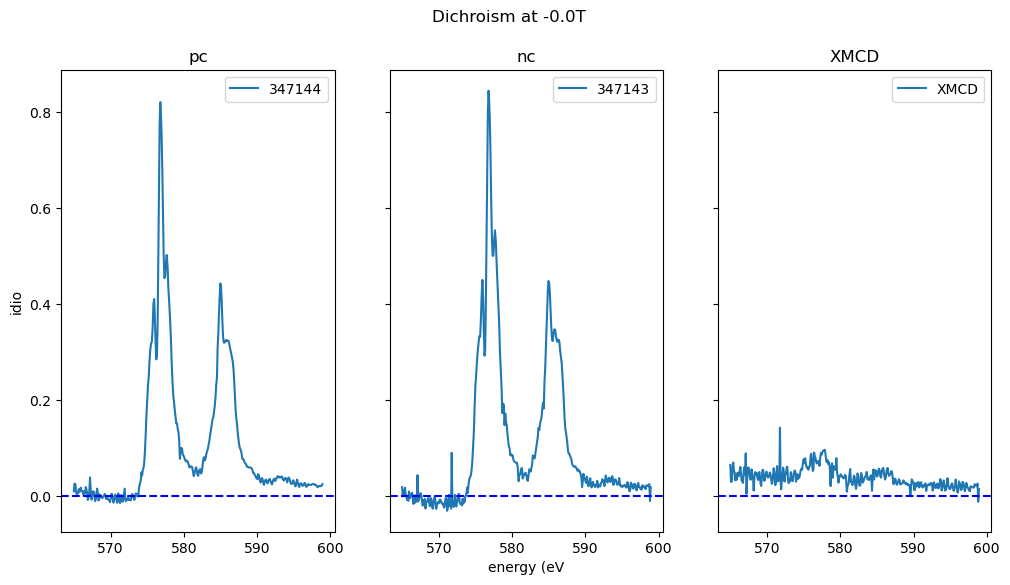

In [161]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347143,347144)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347145
347146


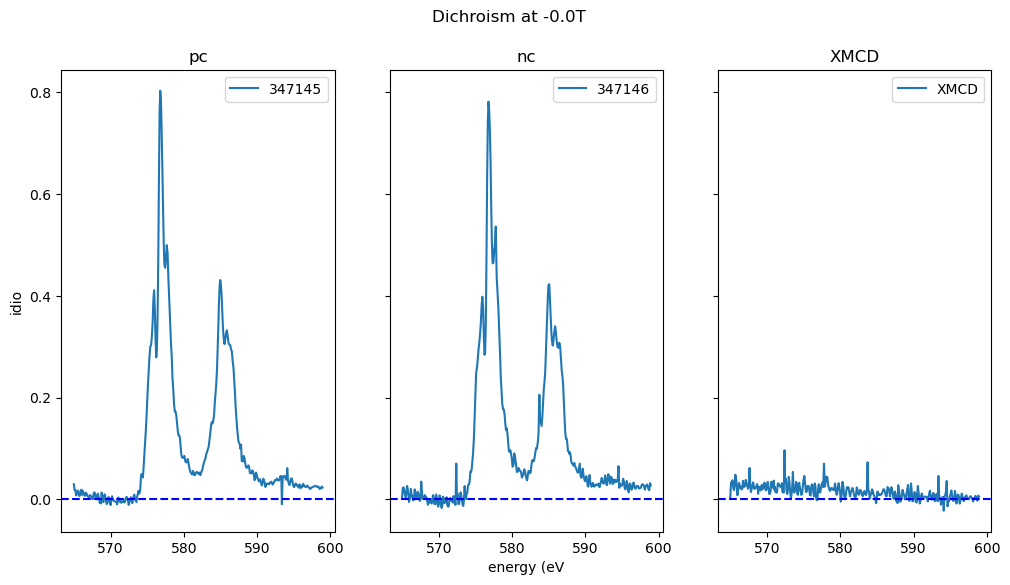

In [164]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347145,347146)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

### Went to -6T and back to 0 so this is remenance

347145
347146
347147
347148
347149
347150
347151
347152
347153
347154


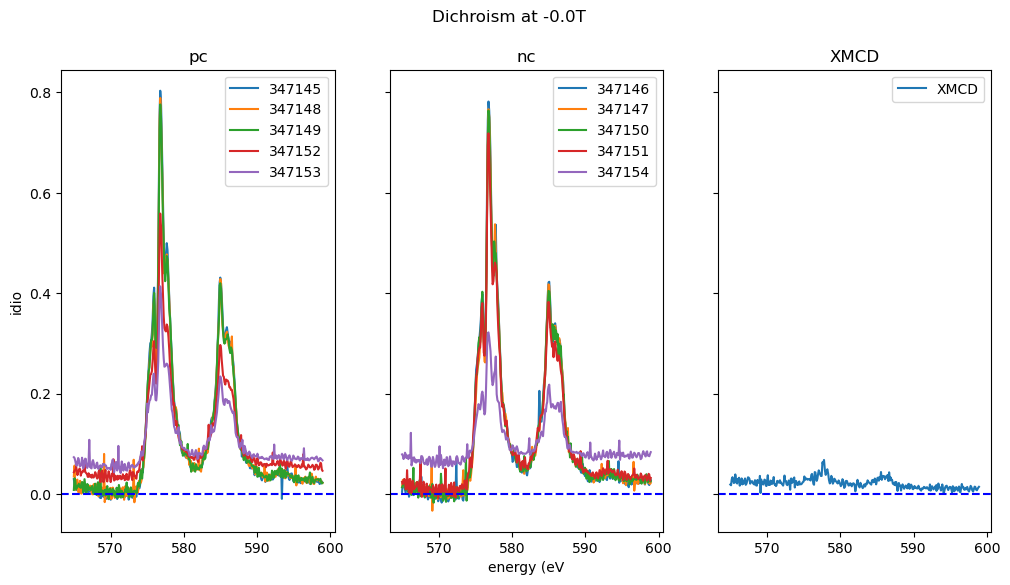

In [167]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347145,347146,347147,347148,347149,347150,347151,347152,347153,347154)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347145
347146


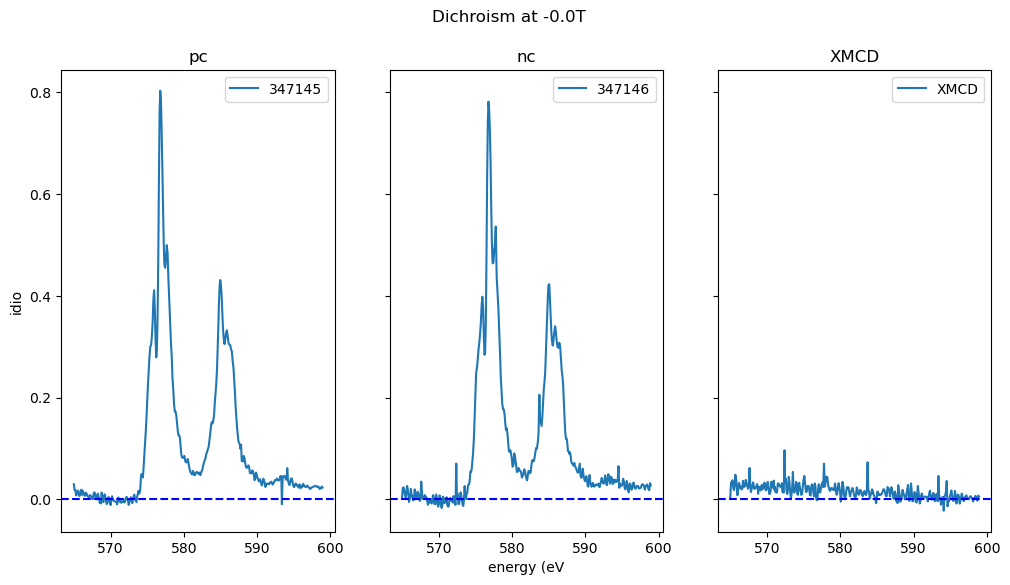

In [168]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347145,347146)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347147
347148


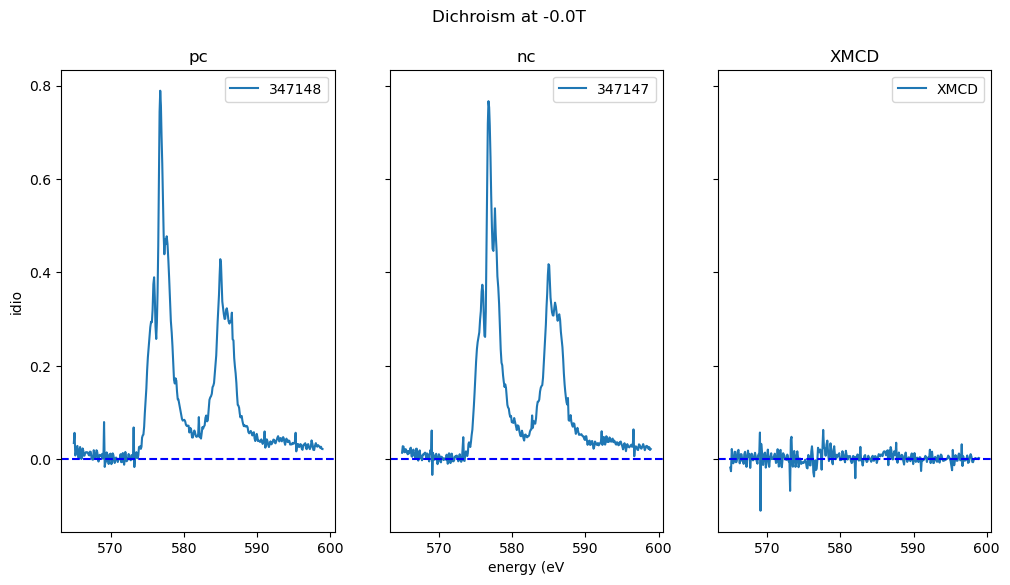

In [169]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347147,347148)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347149
347150


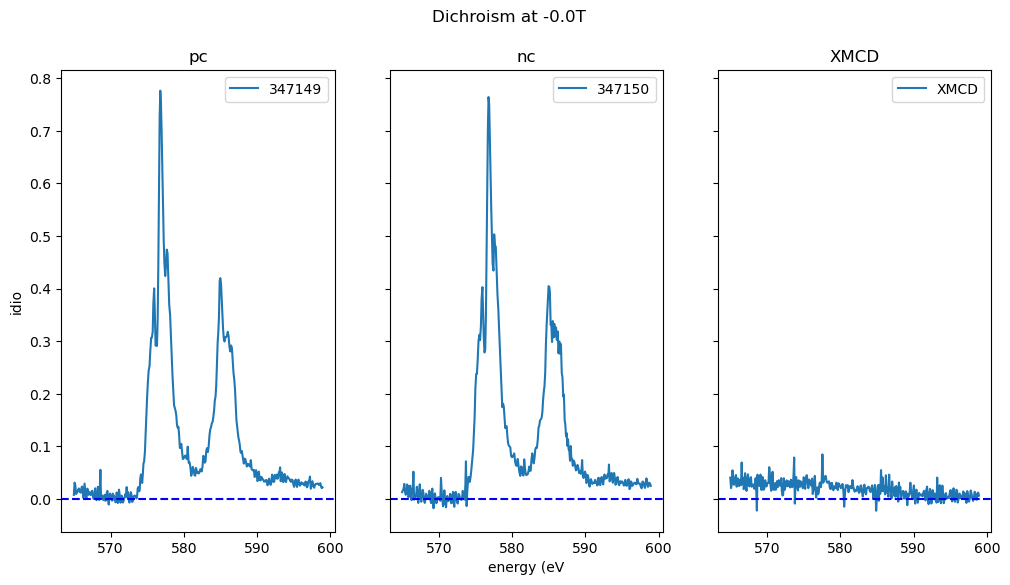

In [170]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347149,347150)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347151
347152


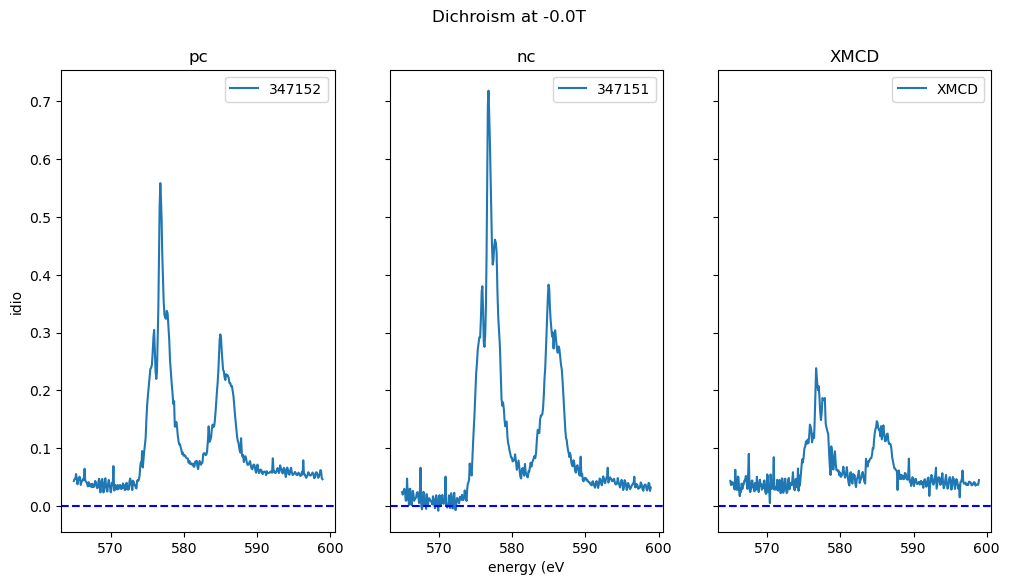

In [171]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347151,347152)
XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

347153
347154


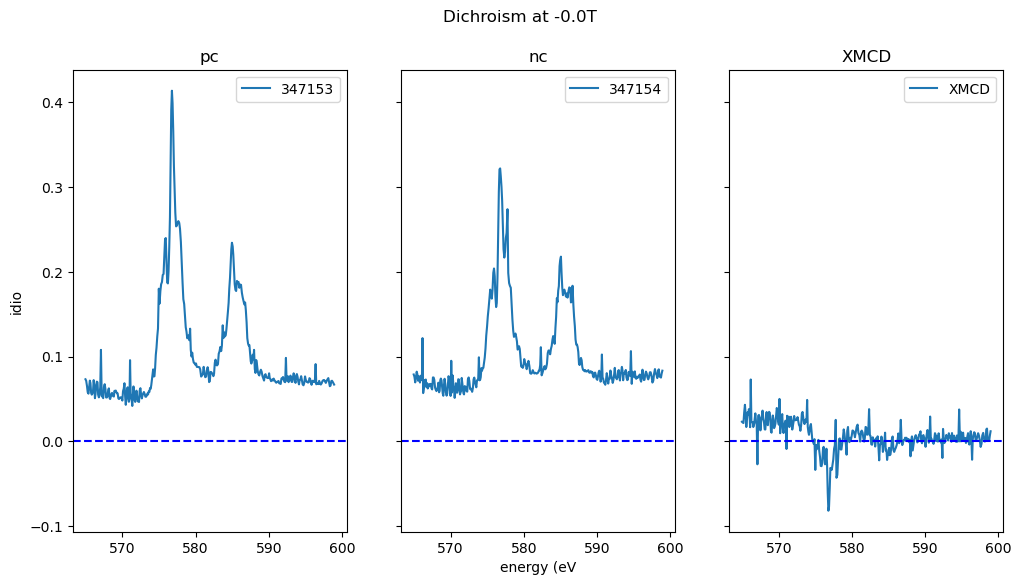

In [173]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347153,347154)2025-01-29 23:00:53,836 INFO  gda.data.fileregistrar.FileRegistrar - icatXMLCreator.registerFiles started: datasetId = scan-347150

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set)

## These look BAD right? Do 1 scan (347155) to check

347147
347148
347149
347150
347151
347152
347153
347154
347155
347156


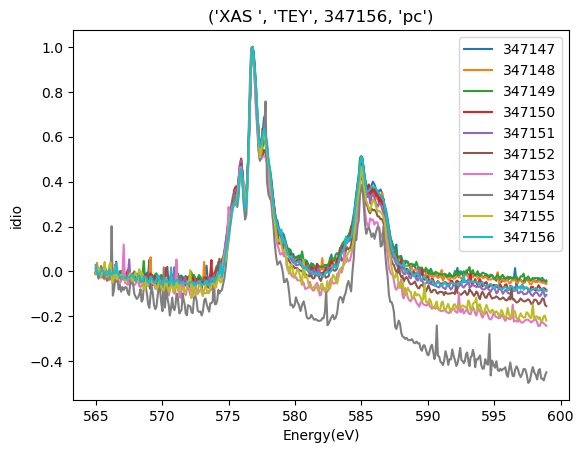

In [181]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set= [347147,347148,347149,347150,347151,347152,347153,347154,347155,347156]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i ,normalisation=5)  

23:17 Moving m7pitch. 6550 (55)-> 6500 (56) -> 6450 (57)-> 6350 (58) -> 6300 (59)

347155
347156
347157
347158
347159


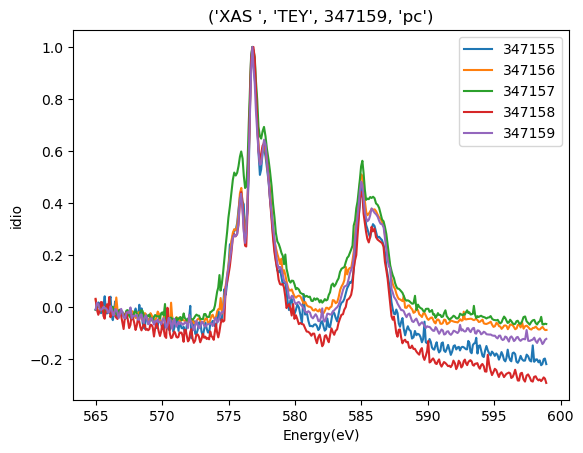

In [187]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set= [347155, 347156, 347157,347158,347159]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i ,normalisation=5)  

347155
347156
347157
347158
347159


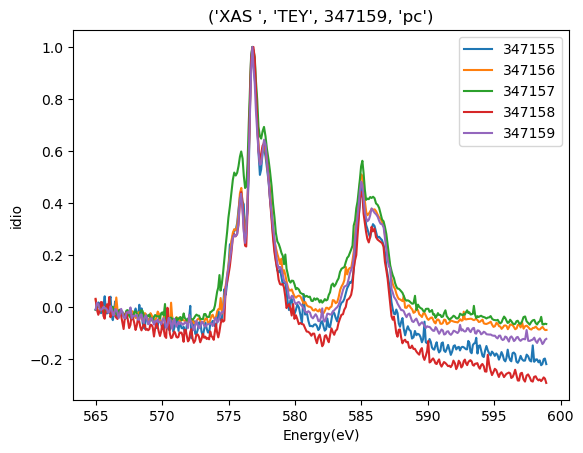

In [187]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/Checking for beam damage/"
XAS_ﬁle_set= [347155, 347156, 347157,347158,347159]

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XAS_ﬁle_set,sensor)

for i in range(0,len(XAS_file_set)):
    XMCD.plot_spectra(XAS_file_set, i ,normalisation=5)  

### Seems to have drifted quite far off top of sample. So thats probably causing some sort of issue.

### Moved angle to 60 degs gonna try and get back t

347188
347189


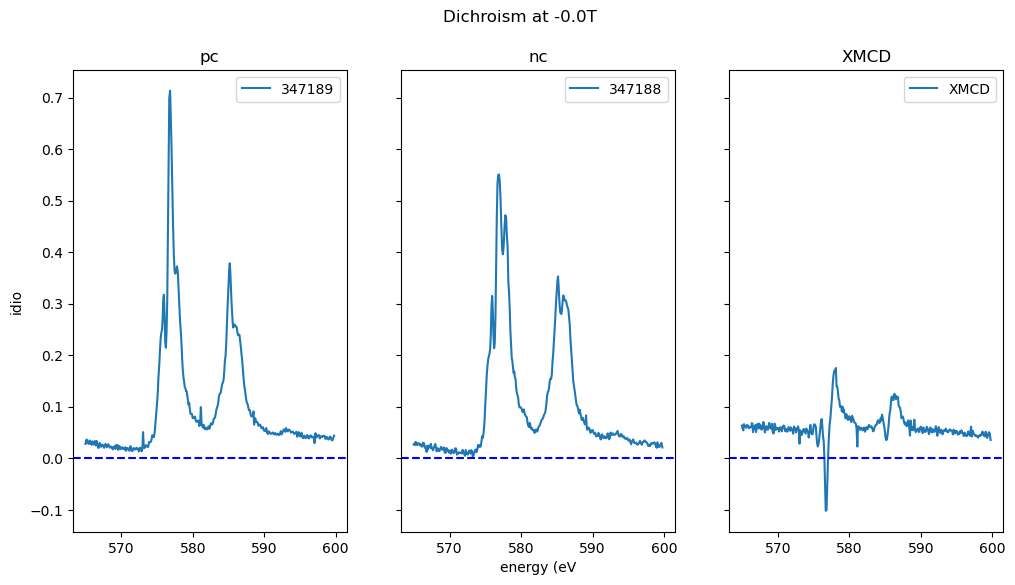

In [190]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347188,347189)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

In [191]:
###This is the signal at 30deg and 0T - clear dichroism!!

347190
347191


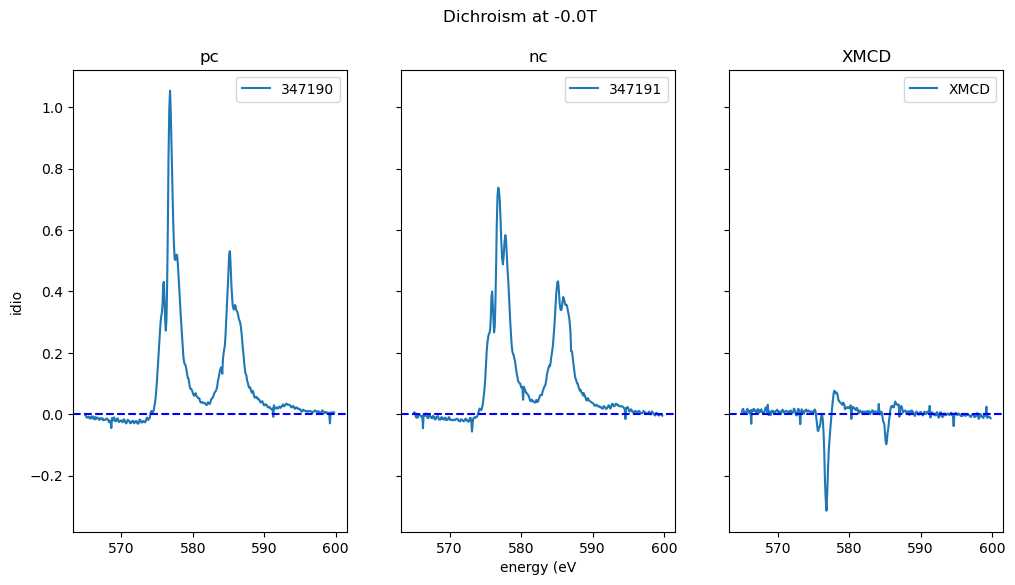

In [192]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347190,347191)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

In [ ]:
##Try 15 degrees

347194
347195
-0.0


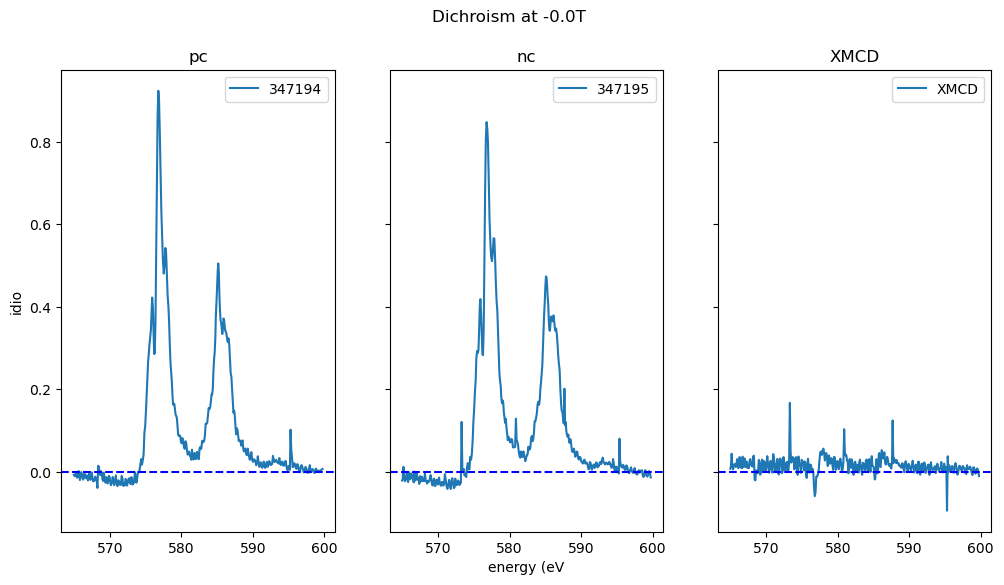

In [259]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347194,347195)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

In [ ]:
## Normal

347196
347197
-0.0


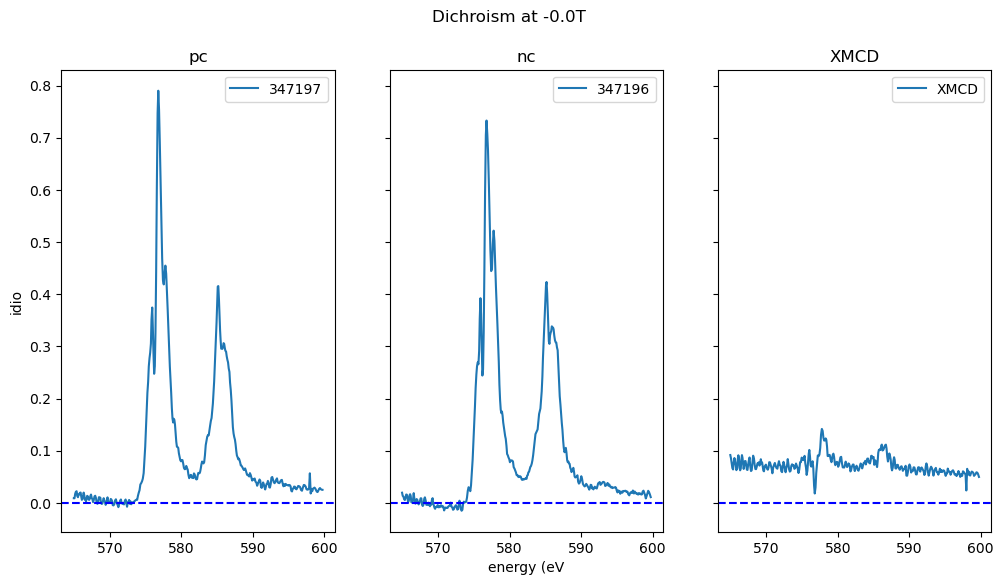

In [258]:
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347196,347197)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347202
347203


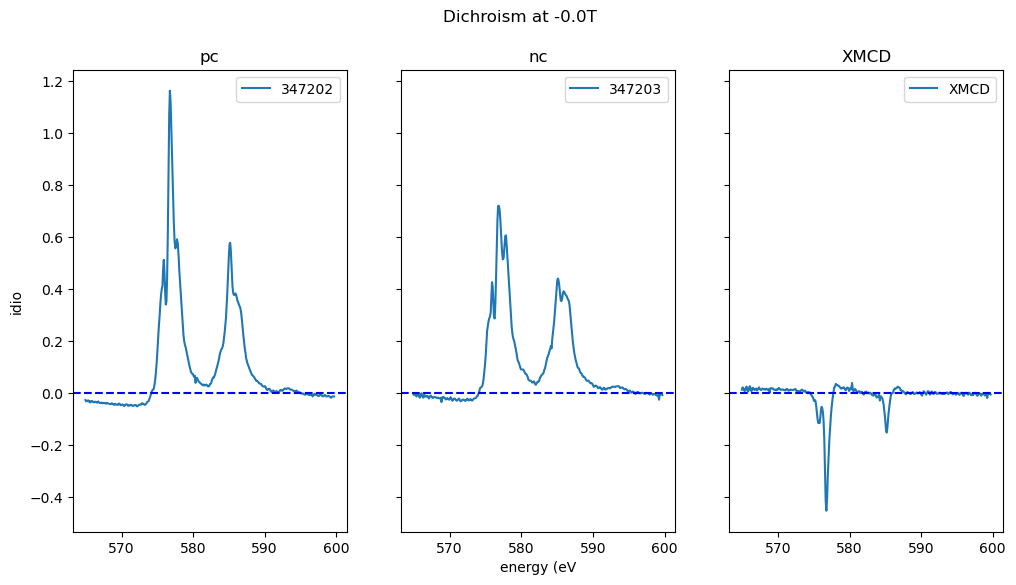

In [197]:
##45deg
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347202,347203)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347204
347205


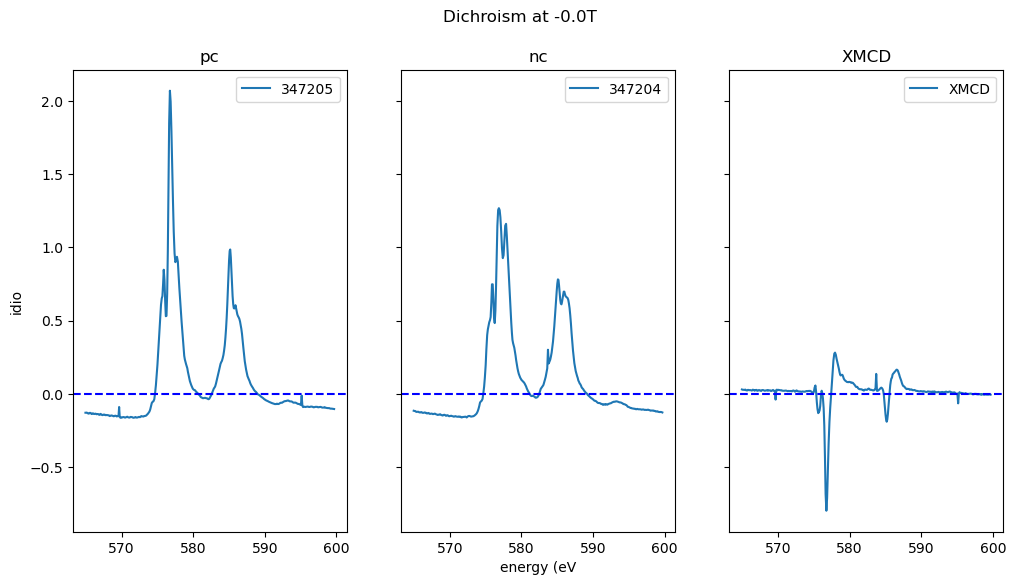

In [200]:
##60deg
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347204,347205)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347208
347209
-0.0


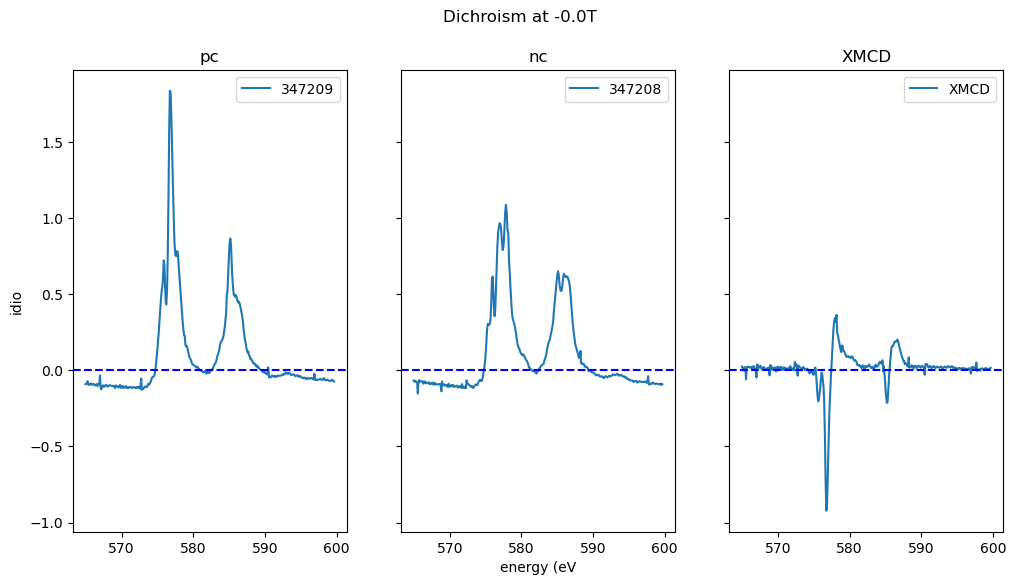

In [257]:
##60deg
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347208,347209)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347210
347211
-0.0


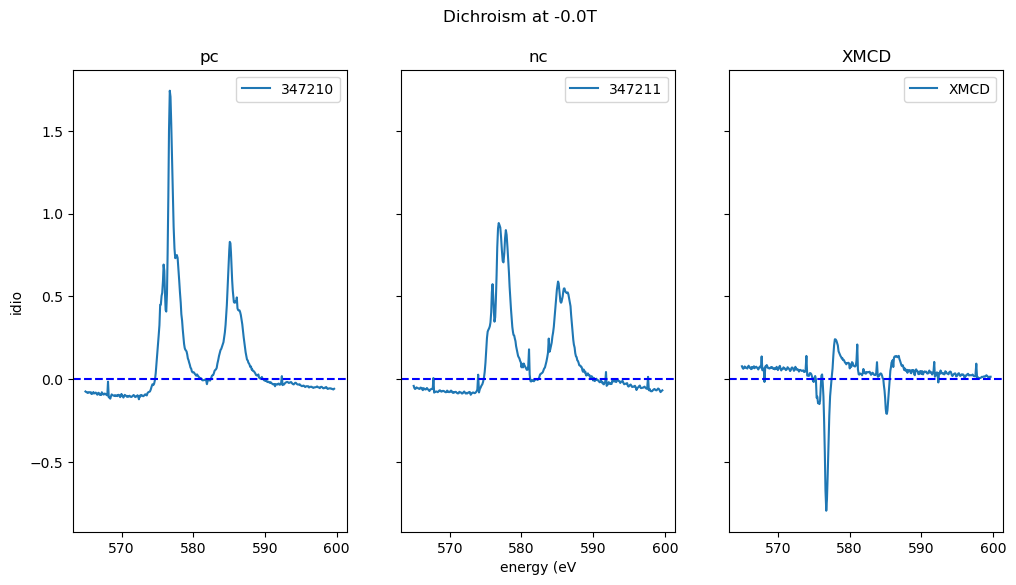

In [256]:
##60deg
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347210,347211)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347212
347213
-0.0


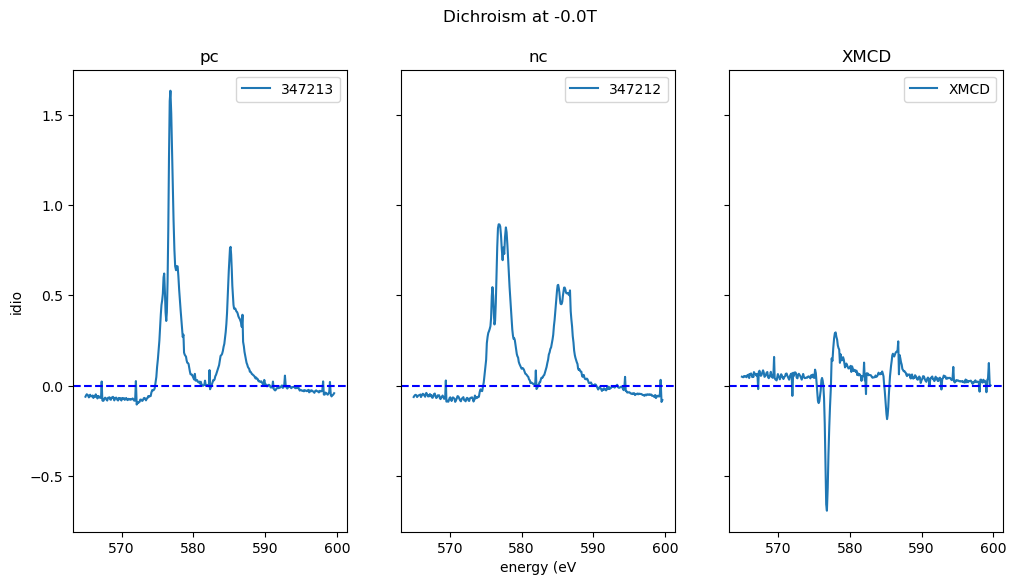

In [255]:
##60deg
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347212,347213)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347214
347215


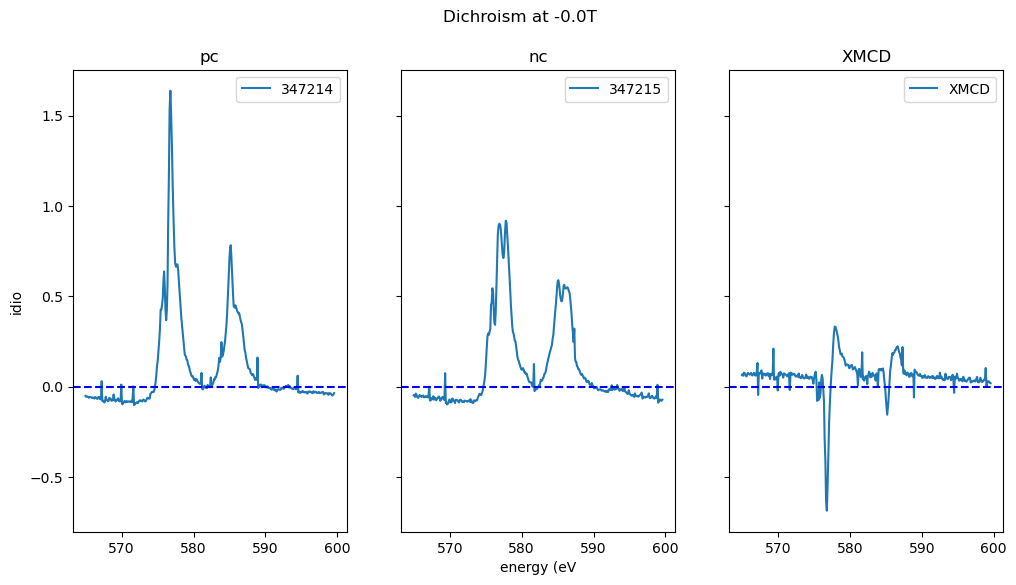

In [204]:
##60deg
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347214,347215)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347217
347218


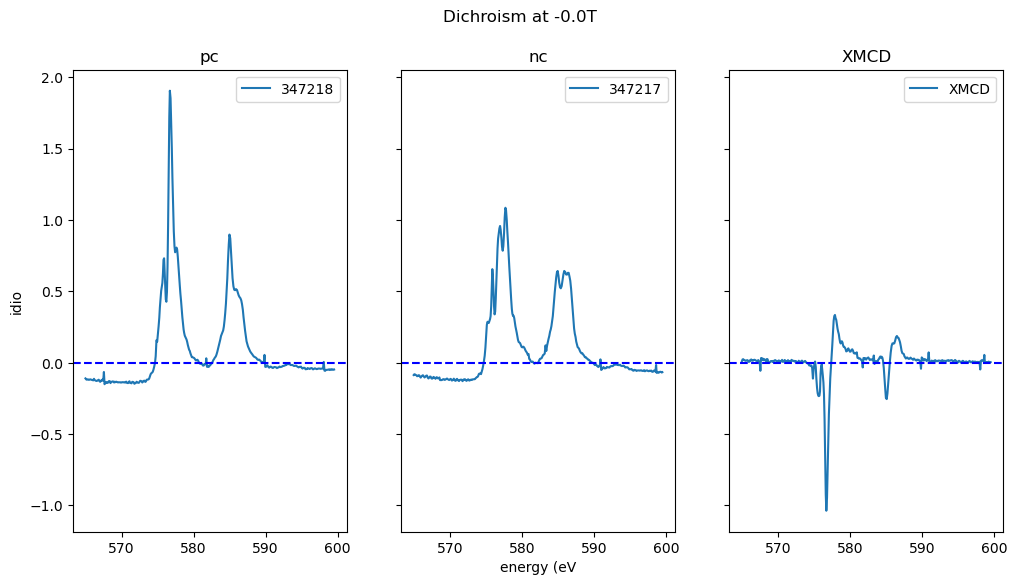

In [210]:
##60deg - still remenance but with better illumination
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347217,347218)
#XMCD_ﬁle_Set = (347219,347220)
#XMCD_ﬁle_Set = (347221,347222)
#XMCD_ﬁle_Set = (347223,347224)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347225
347226


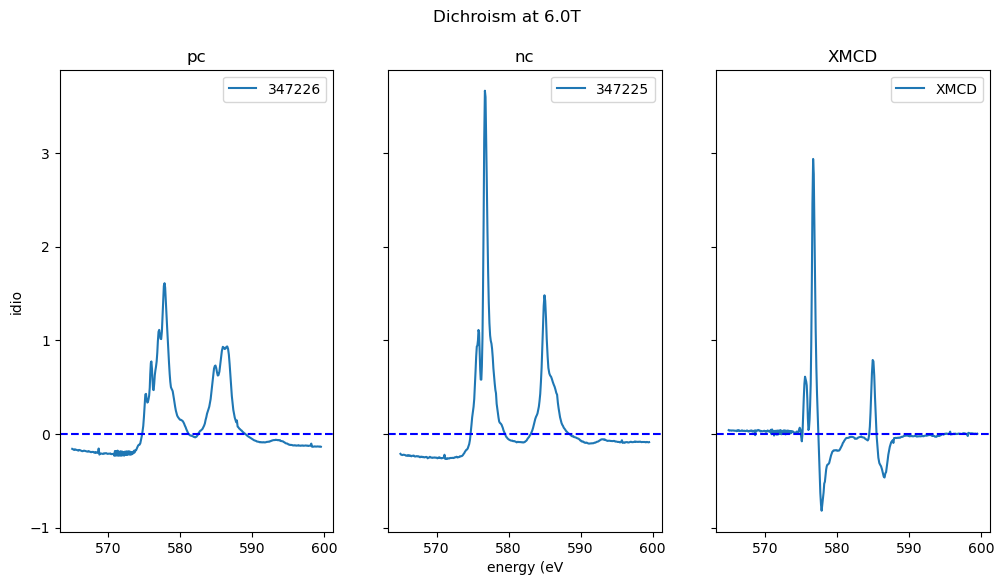

In [215]:
##60deg - 6T
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347225,347226)
#XMCD_ﬁle_Set = (347227,347228)
#XMCD_ﬁle_Set = (347229,347230)
#XMCD_ﬁle_Set = (347231,347232)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347237
347238
0.0


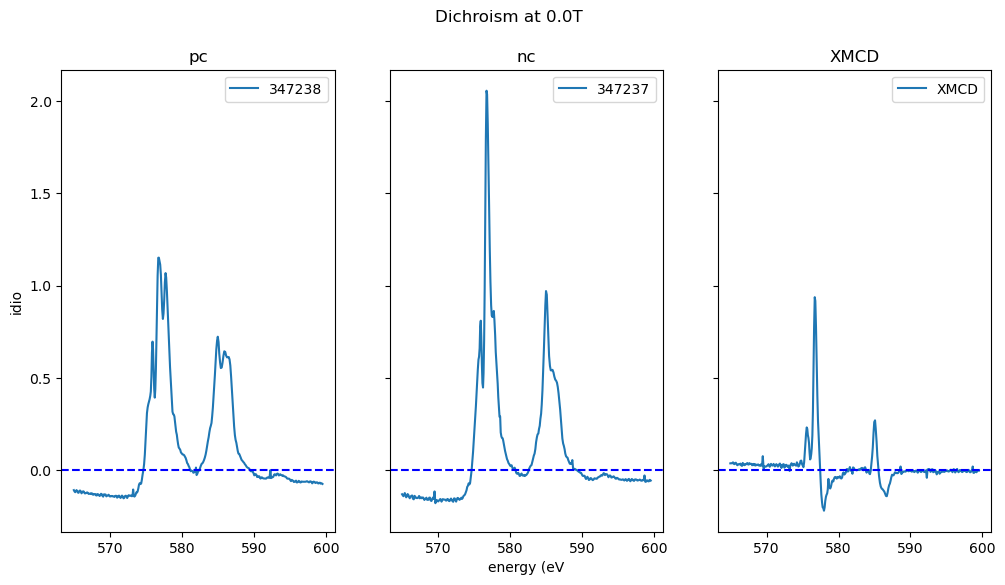

In [254]:
##60deg - Positive Remenance
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
#XMCD_ﬁle_Set = (347233,347234)
#XMCD_ﬁle_Set = (347235,347236)
XMCD_ﬁle_Set = (347237,347238)
#XMCD_ﬁle_Set = (347239,347240)

XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347241
347242
-6.004


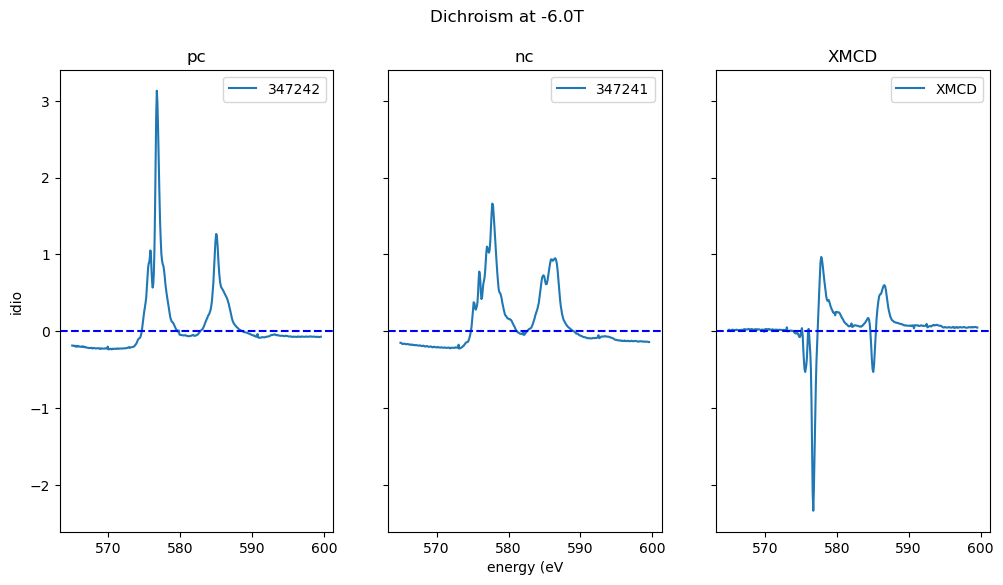

In [252]:
##60deg - -6T
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347241,347242)
#XMCD_ﬁle_Set = (347243,347244)


XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347245
347246
-0.0


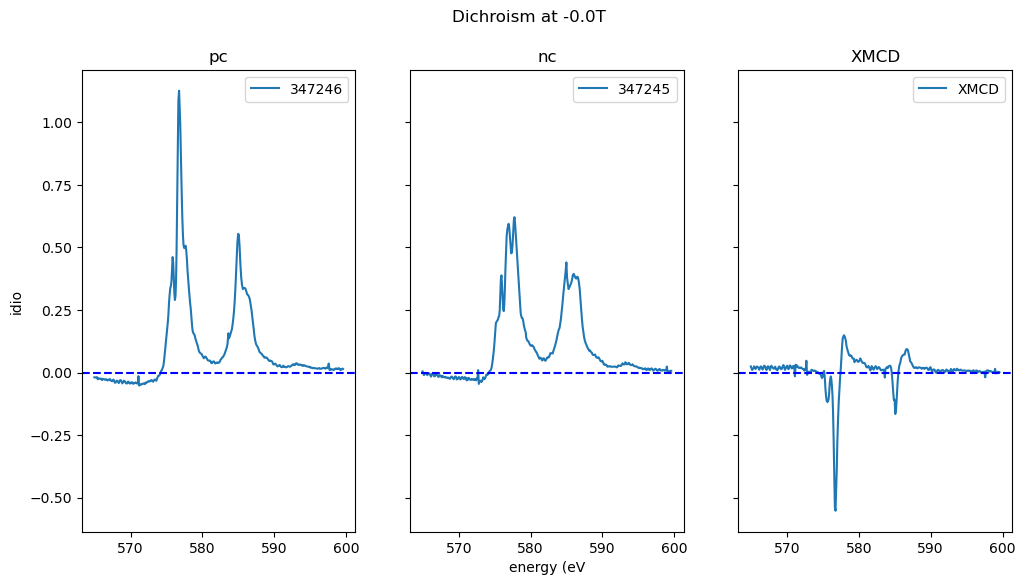

In [250]:
##60deg - Negative Remenance
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347245,347246)2025-01-30 06:18:22,252 INFO  ScriptLogger - Axis 1 is at 0.0, within 6.0, returning 0.0

#XMCD_ﬁle_Set = (347247,347248)


XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347249
347250
0.0103


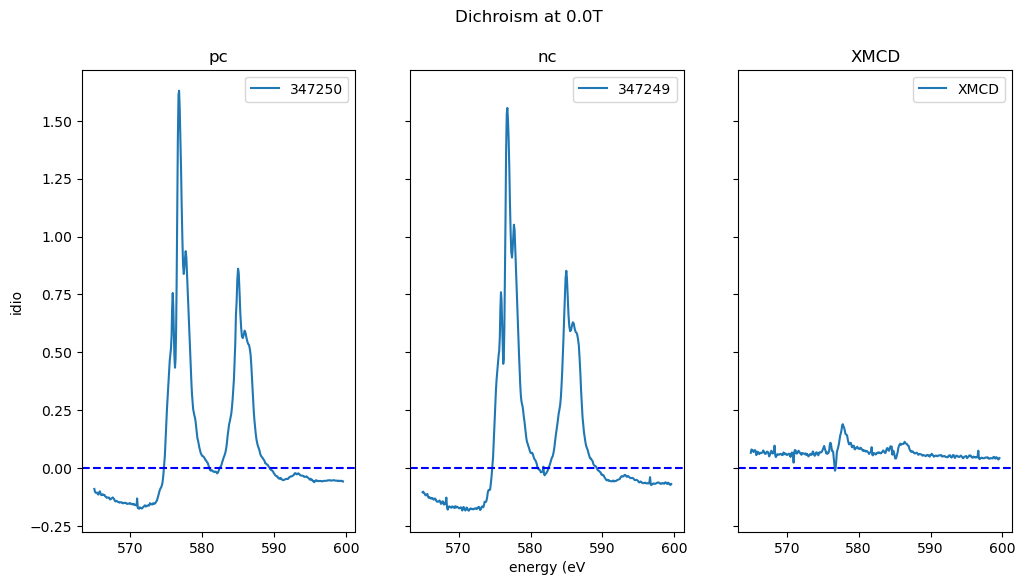

In [247]:
##60deg - 10mT Coercive Field (not quite Hc - still a bit of dichroism in the same direction as 0T)
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347249,347250)
2025-01-30 06:18:22,252 INFO  ScriptLogger - Axis 1 is at 0.0, within 6.0, returning 0.0



XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347251
347252


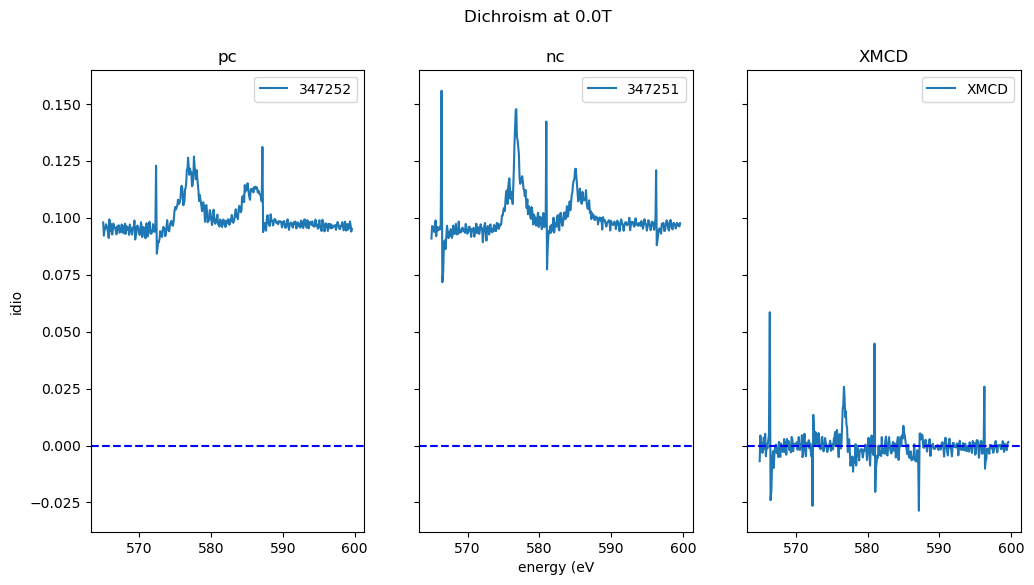

In [231]:
##60deg - 50mT Coercive Field
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347251,347252)



XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347253
347254
0.1004


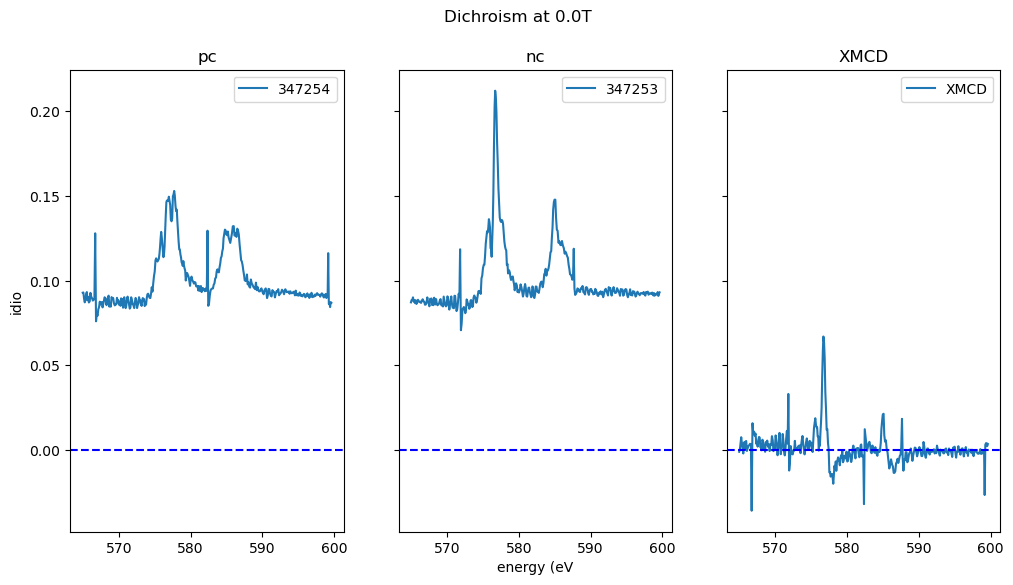

In [246]:
##60deg - 100mT Coercive Field 
sensor = "TEY"
directory_path = r"FILES/HOPG1/jan_29_XMCD/"
XMCD_ﬁle_Set = (347253,347254)



XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347255
347256
0.2005


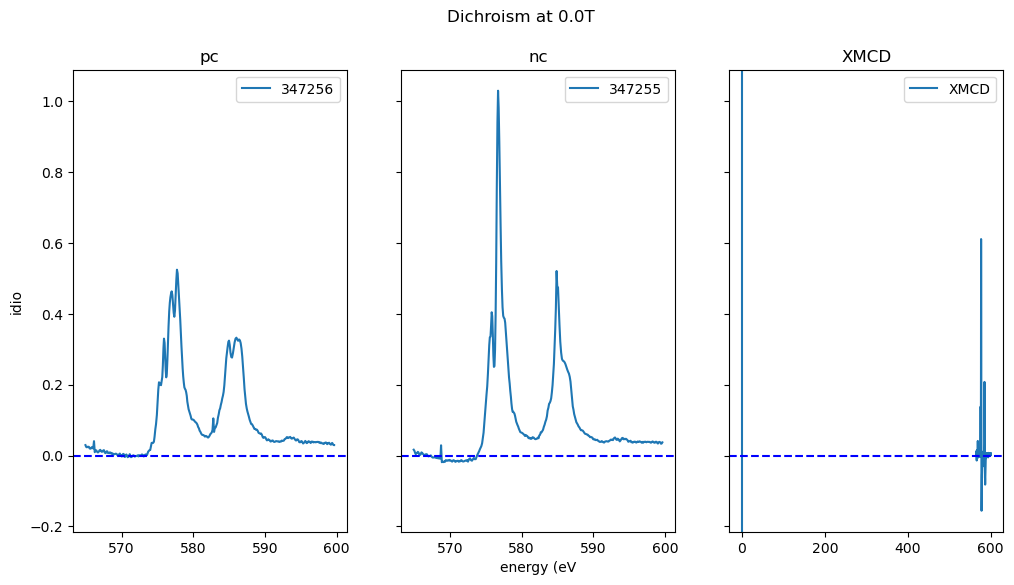

In [285]:
##60deg - 200mT Coercive Field 
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347255,347256)



XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 

347257
347258
0.4005


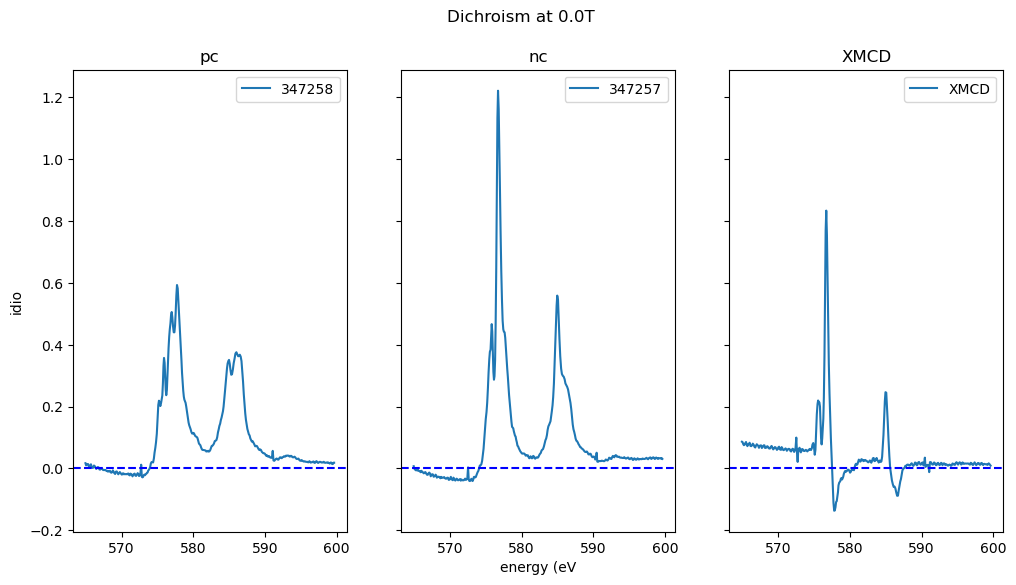

In [288]:
##60deg - 400mT Coercive Field 
sensor = "TEY"
directory_path = r"FILES/HOPG1/XMCD/"
XMCD_ﬁle_Set = (347257,347258)

#2025-01-30 05:08:09,465 INFO  EnergyConsolidationClass:iddrpenergy - delayedSwitchAndMoveEnergy(): iddpol.isBusy()=True


XMCD = prelimenary_code(directory_path, ﬁle_preﬁx, XMCD_ﬁle_Set,sensor)
energy,dichroism = XMCD.Dichroism(XMCD_ﬁle_Set) 
